# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()
env.close()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1000,) (1000, 4) (1000,) (1000,)
dtypes: float64 float64 int64 bool
states: 2.8395687444554043 -2.7770193427962564
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [11]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [13]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [14]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [77]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [78]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [79]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [80]:
def model_loss(action_size, hidden_size, # model init
               states, actions, targetQs, reward): # model input
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward 
    # reward = episode_total_reward/goal_total_reward
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True) # Q=sum(rewards)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.nn.sigmoid(Qs_label)))    
    return actions_logits, Qs_logits, g_loss, d_loss

In [81]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [82]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [83]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(33, 4) actions:(33,)
action size:2


In [84]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [85]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [86]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [96]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        #for step in (111111111111):
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            targetQ = Q_logits * (1-float(done))
            batch.append([state, action, targetQ])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                resulting_reward = total_reward/200 # success is 200 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        #print(targetQs.shape)
        g_loss, d_loss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt], 
                             feed_dict = {model.states: states, 
                                          model.actions: actions,
                                          model.reward: resulting_reward, 
                                          model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode: {}'.format(ep),
              'mean_episodes_total_reward: {:.4f}'.format(np.mean(episodes_total_reward)),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) == 200:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 mean_episodes_total_reward: 9.0000 g_loss: 0.7098 d_loss: 0.6794
Episode: 1 mean_episodes_total_reward: 8.5000 g_loss: 0.7133 d_loss: 0.6446
Episode: 2 mean_episodes_total_reward: 8.6667 g_loss: 0.7165 d_loss: 0.6185
Episode: 3 mean_episodes_total_reward: 8.5000 g_loss: 0.7178 d_loss: 0.5938
Episode: 4 mean_episodes_total_reward: 8.4000 g_loss: 0.7190 d_loss: 0.5676
Episode: 5 mean_episodes_total_reward: 8.5000 g_loss: 0.7183 d_loss: 0.5380
Episode: 6 mean_episodes_total_reward: 8.5714 g_loss: 0.7170 d_loss: 0.5187
Episode: 7 mean_episodes_total_reward: 8.6250 g_loss: 0.7144 d_loss: 0.4968
Episode: 8 mean_episodes_total_reward: 8.7778 g_loss: 0.7065 d_loss: 0.4712
Episode: 9 mean_episodes_total_reward: 8.8000 g_loss: 0.7043 d_loss: 0.4509
Episode: 10 mean_episodes_total_reward: 8.9091 g_loss: 0.6939 d_loss: 0.4363
Episode: 11 mean_episodes_total_reward: 9.0000 g_loss: 0.6843 d_loss: 0.4159
Episode: 12 mean_episodes_total_reward: 9.0769 g_loss: 0.6744 d_loss: 0.3993
Episode: 

Episode: 114 mean_episodes_total_reward: 15.7300 g_loss: 0.2471 d_loss: 0.2916
Episode: 115 mean_episodes_total_reward: 15.8100 g_loss: 0.2577 d_loss: 0.2795
Episode: 116 mean_episodes_total_reward: 15.8800 g_loss: 0.2523 d_loss: 0.2795
Episode: 117 mean_episodes_total_reward: 15.8900 g_loss: 0.3140 d_loss: 0.2173
Episode: 118 mean_episodes_total_reward: 15.9400 g_loss: 0.2582 d_loss: 0.2549
Episode: 119 mean_episodes_total_reward: 15.9500 g_loss: 0.3311 d_loss: 0.2035
Episode: 120 mean_episodes_total_reward: 15.9800 g_loss: 0.2875 d_loss: 0.2290
Episode: 121 mean_episodes_total_reward: 16.0000 g_loss: 0.2983 d_loss: 0.2159
Episode: 122 mean_episodes_total_reward: 16.0100 g_loss: 0.3204 d_loss: 0.2022
Episode: 123 mean_episodes_total_reward: 16.0400 g_loss: 0.2521 d_loss: 0.2420
Episode: 124 mean_episodes_total_reward: 16.0900 g_loss: 0.2561 d_loss: 0.2418
Episode: 125 mean_episodes_total_reward: 16.1000 g_loss: 0.3197 d_loss: 0.2020
Episode: 126 mean_episodes_total_reward: 16.1100 g_l

Episode: 220 mean_episodes_total_reward: 20.5000 g_loss: 0.3385 d_loss: 0.3492
Episode: 221 mean_episodes_total_reward: 20.6300 g_loss: 0.3250 d_loss: 0.3680
Episode: 222 mean_episodes_total_reward: 20.7300 g_loss: 0.3547 d_loss: 0.3305
Episode: 223 mean_episodes_total_reward: 20.8000 g_loss: 0.3502 d_loss: 0.3302
Episode: 224 mean_episodes_total_reward: 20.8900 g_loss: 0.3319 d_loss: 0.3489
Episode: 225 mean_episodes_total_reward: 20.9600 g_loss: 0.3724 d_loss: 0.3011
Episode: 226 mean_episodes_total_reward: 21.0100 g_loss: 0.3706 d_loss: 0.2900
Episode: 227 mean_episodes_total_reward: 21.0800 g_loss: 0.3372 d_loss: 0.3076
Episode: 228 mean_episodes_total_reward: 21.0300 g_loss: 0.3620 d_loss: 0.2766
Episode: 229 mean_episodes_total_reward: 21.0100 g_loss: 0.3424 d_loss: 0.2969
Episode: 230 mean_episodes_total_reward: 20.3700 g_loss: 0.3438 d_loss: 0.2633
Episode: 231 mean_episodes_total_reward: 19.9100 g_loss: 0.3255 d_loss: 0.2722
Episode: 232 mean_episodes_total_reward: 19.6500 g_l

Episode: 324 mean_episodes_total_reward: 20.4500 g_loss: 0.1986 d_loss: 0.3735
Episode: 325 mean_episodes_total_reward: 20.5000 g_loss: 0.2121 d_loss: 0.3506
Episode: 326 mean_episodes_total_reward: 20.5100 g_loss: 0.2324 d_loss: 0.2925
Episode: 327 mean_episodes_total_reward: 20.5100 g_loss: 0.2875 d_loss: 0.3039
Episode: 328 mean_episodes_total_reward: 20.4800 g_loss: 0.2780 d_loss: 0.2299
Episode: 329 mean_episodes_total_reward: 20.4300 g_loss: 0.2713 d_loss: 0.2305
Episode: 330 mean_episodes_total_reward: 20.3900 g_loss: 0.3133 d_loss: 0.2035
Episode: 331 mean_episodes_total_reward: 20.3400 g_loss: 0.2938 d_loss: 0.2047
Episode: 332 mean_episodes_total_reward: 20.3000 g_loss: 0.3599 d_loss: 0.1925
Episode: 333 mean_episodes_total_reward: 20.2700 g_loss: 0.3720 d_loss: 0.1928
Episode: 334 mean_episodes_total_reward: 20.3300 g_loss: 0.2693 d_loss: 0.2704
Episode: 335 mean_episodes_total_reward: 20.3400 g_loss: 0.3165 d_loss: 0.2580
Episode: 336 mean_episodes_total_reward: 20.3600 g_l

Episode: 433 mean_episodes_total_reward: 22.5000 g_loss: 0.2945 d_loss: 0.3576
Episode: 434 mean_episodes_total_reward: 22.5100 g_loss: 0.3516 d_loss: 0.2867
Episode: 435 mean_episodes_total_reward: 22.5600 g_loss: 0.2916 d_loss: 0.3158
Episode: 436 mean_episodes_total_reward: 22.6200 g_loss: 0.3098 d_loss: 0.2829
Episode: 437 mean_episodes_total_reward: 22.6700 g_loss: 0.2855 d_loss: 0.2701
Episode: 438 mean_episodes_total_reward: 22.6200 g_loss: 0.3155 d_loss: 0.2347
Episode: 439 mean_episodes_total_reward: 22.4100 g_loss: 0.3603 d_loss: 0.2115
Episode: 440 mean_episodes_total_reward: 22.3200 g_loss: 0.3811 d_loss: 0.1985
Episode: 441 mean_episodes_total_reward: 22.1600 g_loss: 0.3184 d_loss: 0.2223
Episode: 442 mean_episodes_total_reward: 22.0300 g_loss: 0.3018 d_loss: 0.2335
Episode: 443 mean_episodes_total_reward: 21.5900 g_loss: 0.3066 d_loss: 0.2460
Episode: 444 mean_episodes_total_reward: 21.5500 g_loss: 0.3081 d_loss: 0.2703
Episode: 445 mean_episodes_total_reward: 21.5500 g_l

Episode: 539 mean_episodes_total_reward: 24.9200 g_loss: 0.3881 d_loss: 0.5011
Episode: 540 mean_episodes_total_reward: 25.4300 g_loss: 0.3109 d_loss: 0.6422
Episode: 541 mean_episodes_total_reward: 25.8500 g_loss: 0.3313 d_loss: 0.5946
Episode: 542 mean_episodes_total_reward: 25.9400 g_loss: 0.3978 d_loss: 0.3507
Episode: 543 mean_episodes_total_reward: 26.0000 g_loss: 0.4371 d_loss: 0.3395
Episode: 544 mean_episodes_total_reward: 25.9800 g_loss: 0.4384 d_loss: 0.2772
Episode: 545 mean_episodes_total_reward: 27.8800 g_loss: -0.2534 d_loss: 1.6097
Episode: 546 mean_episodes_total_reward: 28.4800 g_loss: 0.2091 d_loss: 0.7587
Episode: 547 mean_episodes_total_reward: 28.5100 g_loss: 0.4785 d_loss: 0.2838
Episode: 548 mean_episodes_total_reward: 28.5000 g_loss: 0.4839 d_loss: 0.2510
Episode: 549 mean_episodes_total_reward: 28.3700 g_loss: 0.4646 d_loss: 0.2568
Episode: 550 mean_episodes_total_reward: 28.2600 g_loss: 0.4596 d_loss: 0.2564
Episode: 551 mean_episodes_total_reward: 28.1900 g_

Episode: 646 mean_episodes_total_reward: 22.8900 g_loss: -0.3392 d_loss: 1.4840
Episode: 647 mean_episodes_total_reward: 23.0200 g_loss: 0.3354 d_loss: 0.3919
Episode: 648 mean_episodes_total_reward: 23.5900 g_loss: 0.0411 d_loss: 0.7899
Episode: 649 mean_episodes_total_reward: 23.5900 g_loss: 0.3432 d_loss: 0.2279
Episode: 650 mean_episodes_total_reward: 23.6200 g_loss: 0.2980 d_loss: 0.2620
Episode: 651 mean_episodes_total_reward: 23.5900 g_loss: 0.3808 d_loss: 0.2173
Episode: 652 mean_episodes_total_reward: 23.6000 g_loss: 0.3785 d_loss: 0.2166
Episode: 653 mean_episodes_total_reward: 23.5600 g_loss: 0.3556 d_loss: 0.2299
Episode: 654 mean_episodes_total_reward: 23.5200 g_loss: 0.3683 d_loss: 0.2318
Episode: 655 mean_episodes_total_reward: 23.5900 g_loss: 0.3441 d_loss: 0.2883
Episode: 656 mean_episodes_total_reward: 23.6700 g_loss: 0.2999 d_loss: 0.2862
Episode: 657 mean_episodes_total_reward: 23.7400 g_loss: 0.3606 d_loss: 0.2900
Episode: 658 mean_episodes_total_reward: 23.7300 g_

Episode: 754 mean_episodes_total_reward: 21.7500 g_loss: 0.2801 d_loss: 0.2580
Episode: 755 mean_episodes_total_reward: 21.7500 g_loss: 0.2505 d_loss: 0.2818
Episode: 756 mean_episodes_total_reward: 21.7400 g_loss: 0.2587 d_loss: 0.2701
Episode: 757 mean_episodes_total_reward: 21.7000 g_loss: 0.2909 d_loss: 0.2331
Episode: 758 mean_episodes_total_reward: 21.6600 g_loss: 0.3267 d_loss: 0.2097
Episode: 759 mean_episodes_total_reward: 21.6000 g_loss: 0.3328 d_loss: 0.2581
Episode: 760 mean_episodes_total_reward: 21.6300 g_loss: 0.2938 d_loss: 0.2646
Episode: 761 mean_episodes_total_reward: 21.7800 g_loss: 0.1755 d_loss: 0.4082
Episode: 762 mean_episodes_total_reward: 21.7900 g_loss: 0.1453 d_loss: 0.5083
Episode: 763 mean_episodes_total_reward: 22.1300 g_loss: 0.1226 d_loss: 0.6015
Episode: 764 mean_episodes_total_reward: 22.1000 g_loss: 0.1938 d_loss: 0.4288
Episode: 765 mean_episodes_total_reward: 22.2200 g_loss: 0.2025 d_loss: 0.4138
Episode: 766 mean_episodes_total_reward: 22.3600 g_l

Episode: 859 mean_episodes_total_reward: 27.8100 g_loss: 0.3150 d_loss: 0.2374
Episode: 860 mean_episodes_total_reward: 27.7800 g_loss: 0.3478 d_loss: 0.2271
Episode: 861 mean_episodes_total_reward: 27.6700 g_loss: 0.3153 d_loss: 0.2730
Episode: 862 mean_episodes_total_reward: 27.7200 g_loss: 0.2176 d_loss: 0.5361
Episode: 863 mean_episodes_total_reward: 27.3600 g_loss: 0.3633 d_loss: 0.2293
Episode: 864 mean_episodes_total_reward: 27.1700 g_loss: 0.3877 d_loss: 0.2174
Episode: 865 mean_episodes_total_reward: 28.0200 g_loss: -0.1174 d_loss: 1.1292
Episode: 866 mean_episodes_total_reward: 27.8800 g_loss: 0.3163 d_loss: 0.2372
Episode: 867 mean_episodes_total_reward: 27.7400 g_loss: 0.3879 d_loss: 0.2030
Episode: 868 mean_episodes_total_reward: 28.2100 g_loss: 0.1331 d_loss: 0.6885
Episode: 869 mean_episodes_total_reward: 29.3400 g_loss: -0.1611 d_loss: 1.2102
Episode: 870 mean_episodes_total_reward: 29.6400 g_loss: 0.2649 d_loss: 0.5331
Episode: 871 mean_episodes_total_reward: 29.4400 g

Episode: 968 mean_episodes_total_reward: 24.9200 g_loss: -0.0930 d_loss: 0.9904
Episode: 969 mean_episodes_total_reward: 23.8100 g_loss: 0.3472 d_loss: 0.2316
Episode: 970 mean_episodes_total_reward: 23.4800 g_loss: 0.3617 d_loss: 0.1987
Episode: 971 mean_episodes_total_reward: 23.4900 g_loss: 0.2682 d_loss: 0.2388
Episode: 972 mean_episodes_total_reward: 23.5100 g_loss: 0.2817 d_loss: 0.2378
Episode: 973 mean_episodes_total_reward: 23.9300 g_loss: 0.1253 d_loss: 0.6436
Episode: 974 mean_episodes_total_reward: 23.9600 g_loss: 0.2641 d_loss: 0.2356
Episode: 975 mean_episodes_total_reward: 23.9500 g_loss: 0.3571 d_loss: 0.1978
Episode: 976 mean_episodes_total_reward: 23.9200 g_loss: 0.2666 d_loss: 0.2368
Episode: 977 mean_episodes_total_reward: 23.8700 g_loss: 0.3207 d_loss: 0.2096
Episode: 978 mean_episodes_total_reward: 24.1600 g_loss: 0.2409 d_loss: 0.5311
Episode: 979 mean_episodes_total_reward: 24.9300 g_loss: -0.0014 d_loss: 0.9609
Episode: 980 mean_episodes_total_reward: 25.0700 g

Episode: 1073 mean_episodes_total_reward: 28.7500 g_loss: 0.5225 d_loss: 0.4191
Episode: 1074 mean_episodes_total_reward: 28.8500 g_loss: 0.3946 d_loss: 0.3667
Episode: 1075 mean_episodes_total_reward: 28.8700 g_loss: 0.5122 d_loss: 0.2785
Episode: 1076 mean_episodes_total_reward: 28.8400 g_loss: 0.5363 d_loss: 0.2616
Episode: 1077 mean_episodes_total_reward: 28.8400 g_loss: 0.5238 d_loss: 0.2707
Episode: 1078 mean_episodes_total_reward: 28.5200 g_loss: 0.4150 d_loss: 0.2145
Episode: 1079 mean_episodes_total_reward: 27.7000 g_loss: 0.3739 d_loss: 0.2215
Episode: 1080 mean_episodes_total_reward: 27.5300 g_loss: 0.4886 d_loss: 0.3023
Episode: 1081 mean_episodes_total_reward: 27.5200 g_loss: 0.4954 d_loss: 0.2938
Episode: 1082 mean_episodes_total_reward: 27.5100 g_loss: 0.4951 d_loss: 0.3039
Episode: 1083 mean_episodes_total_reward: 27.5000 g_loss: 0.4974 d_loss: 0.2935
Episode: 1084 mean_episodes_total_reward: 27.5000 g_loss: 0.4711 d_loss: 0.3054
Episode: 1085 mean_episodes_total_reward

Episode: 1176 mean_episodes_total_reward: 25.7600 g_loss: -0.0924 d_loss: 1.2186
Episode: 1177 mean_episodes_total_reward: 26.7600 g_loss: 0.1352 d_loss: 0.9783
Episode: 1178 mean_episodes_total_reward: 27.0100 g_loss: 0.3696 d_loss: 0.4642
Episode: 1179 mean_episodes_total_reward: 27.0200 g_loss: 0.4334 d_loss: 0.2542
Episode: 1180 mean_episodes_total_reward: 26.9800 g_loss: 0.3865 d_loss: 0.2259
Episode: 1181 mean_episodes_total_reward: 27.0800 g_loss: 0.4100 d_loss: 0.3808
Episode: 1182 mean_episodes_total_reward: 27.1300 g_loss: 0.4592 d_loss: 0.3412
Episode: 1183 mean_episodes_total_reward: 27.1700 g_loss: 0.4533 d_loss: 0.3223
Episode: 1184 mean_episodes_total_reward: 27.1300 g_loss: 0.4679 d_loss: 0.2608
Episode: 1185 mean_episodes_total_reward: 26.9500 g_loss: 0.4712 d_loss: 0.2622
Episode: 1186 mean_episodes_total_reward: 26.6000 g_loss: 0.4540 d_loss: 0.3121
Episode: 1187 mean_episodes_total_reward: 26.5000 g_loss: 0.4013 d_loss: 0.5171
Episode: 1188 mean_episodes_total_rewar

Episode: 1280 mean_episodes_total_reward: 27.6300 g_loss: 0.3057 d_loss: 0.2180
Episode: 1281 mean_episodes_total_reward: 27.5400 g_loss: 0.2201 d_loss: 0.2624
Episode: 1282 mean_episodes_total_reward: 27.4400 g_loss: 0.3687 d_loss: 0.1990
Episode: 1283 mean_episodes_total_reward: 27.3800 g_loss: 0.3193 d_loss: 0.2244
Episode: 1284 mean_episodes_total_reward: 27.3800 g_loss: 0.3116 d_loss: 0.2229
Episode: 1285 mean_episodes_total_reward: 27.7200 g_loss: 0.2009 d_loss: 0.5754
Episode: 1286 mean_episodes_total_reward: 28.6800 g_loss: -0.0546 d_loss: 1.0957
Episode: 1287 mean_episodes_total_reward: 28.6900 g_loss: 0.2099 d_loss: 0.5356
Episode: 1288 mean_episodes_total_reward: 26.9300 g_loss: 0.3180 d_loss: 0.3691
Episode: 1289 mean_episodes_total_reward: 27.0000 g_loss: 0.2373 d_loss: 0.3493
Episode: 1290 mean_episodes_total_reward: 27.0800 g_loss: 0.2308 d_loss: 0.3054
Episode: 1291 mean_episodes_total_reward: 27.1300 g_loss: 0.2352 d_loss: 0.2836
Episode: 1292 mean_episodes_total_rewar

Episode: 1387 mean_episodes_total_reward: 29.9700 g_loss: 0.4321 d_loss: 0.5080
Episode: 1388 mean_episodes_total_reward: 30.9800 g_loss: 0.4343 d_loss: 0.8965
Episode: 1389 mean_episodes_total_reward: 30.9500 g_loss: 0.4727 d_loss: 0.3543
Episode: 1390 mean_episodes_total_reward: 30.9300 g_loss: 0.4266 d_loss: 0.3120
Episode: 1391 mean_episodes_total_reward: 30.9000 g_loss: 0.4864 d_loss: 0.2980
Episode: 1392 mean_episodes_total_reward: 30.9500 g_loss: 0.4674 d_loss: 0.3291
Episode: 1393 mean_episodes_total_reward: 31.0100 g_loss: 0.4685 d_loss: 0.3478
Episode: 1394 mean_episodes_total_reward: 31.2900 g_loss: 0.5868 d_loss: 0.5434
Episode: 1395 mean_episodes_total_reward: 32.3400 g_loss: 0.8184 d_loss: 0.7611
Episode: 1396 mean_episodes_total_reward: 33.2500 g_loss: 0.6953 d_loss: 0.7516
Episode: 1397 mean_episodes_total_reward: 35.0000 g_loss: -0.0388 d_loss: 1.4484
Episode: 1398 mean_episodes_total_reward: 36.6200 g_loss: 0.0946 d_loss: 1.3501
Episode: 1399 mean_episodes_total_rewar

Episode: 1492 mean_episodes_total_reward: 37.9000 g_loss: -0.1252 d_loss: 1.3345
Episode: 1493 mean_episodes_total_reward: 37.8400 g_loss: 0.2955 d_loss: 0.2452
Episode: 1494 mean_episodes_total_reward: 37.6100 g_loss: 0.3363 d_loss: 0.2772
Episode: 1495 mean_episodes_total_reward: 36.6000 g_loss: 0.3249 d_loss: 0.2752
Episode: 1496 mean_episodes_total_reward: 35.6500 g_loss: 0.3288 d_loss: 0.2388
Episode: 1497 mean_episodes_total_reward: 33.8100 g_loss: 0.3627 d_loss: 0.3072
Episode: 1498 mean_episodes_total_reward: 31.9000 g_loss: 0.3640 d_loss: 0.2072
Episode: 1499 mean_episodes_total_reward: 30.8600 g_loss: 0.3632 d_loss: 0.2300
Episode: 1500 mean_episodes_total_reward: 28.9900 g_loss: 0.3635 d_loss: 0.2566
Episode: 1501 mean_episodes_total_reward: 29.3000 g_loss: 0.2967 d_loss: 0.5263
Episode: 1502 mean_episodes_total_reward: 29.6600 g_loss: 0.3684 d_loss: 0.6077
Episode: 1503 mean_episodes_total_reward: 29.9300 g_loss: 0.4056 d_loss: 0.5044
Episode: 1504 mean_episodes_total_rewar

Episode: 1599 mean_episodes_total_reward: 42.5000 g_loss: 0.5087 d_loss: 0.3241
Episode: 1600 mean_episodes_total_reward: 42.4900 g_loss: 0.5436 d_loss: 0.3164
Episode: 1601 mean_episodes_total_reward: 42.4100 g_loss: 0.4512 d_loss: 0.5125
Episode: 1602 mean_episodes_total_reward: 42.0600 g_loss: 0.5348 d_loss: 0.4113
Episode: 1603 mean_episodes_total_reward: 41.9500 g_loss: 0.5122 d_loss: 0.4665
Episode: 1604 mean_episodes_total_reward: 42.7500 g_loss: 0.3964 d_loss: 0.8441
Episode: 1605 mean_episodes_total_reward: 42.9000 g_loss: 0.5511 d_loss: 0.4311
Episode: 1606 mean_episodes_total_reward: 42.9400 g_loss: 0.5466 d_loss: 0.4311
Episode: 1607 mean_episodes_total_reward: 42.8200 g_loss: 0.5848 d_loss: 0.4102
Episode: 1608 mean_episodes_total_reward: 42.7900 g_loss: 0.5502 d_loss: 0.4739
Episode: 1609 mean_episodes_total_reward: 42.7000 g_loss: 0.5269 d_loss: 0.5344
Episode: 1610 mean_episodes_total_reward: 44.0300 g_loss: 0.3151 d_loss: 1.1952
Episode: 1611 mean_episodes_total_reward

Episode: 1702 mean_episodes_total_reward: 98.6300 g_loss: 0.7516 d_loss: 0.7032
Episode: 1703 mean_episodes_total_reward: 98.9900 g_loss: 0.7346 d_loss: 0.6667
Episode: 1704 mean_episodes_total_reward: 98.6600 g_loss: 0.7346 d_loss: 0.6759
Episode: 1705 mean_episodes_total_reward: 99.1300 g_loss: 0.7342 d_loss: 0.6738
Episode: 1706 mean_episodes_total_reward: 99.4900 g_loss: 0.7300 d_loss: 0.6625
Episode: 1707 mean_episodes_total_reward: 99.9400 g_loss: 0.7296 d_loss: 0.6667
Episode: 1708 mean_episodes_total_reward: 100.4500 g_loss: 0.7307 d_loss: 0.6820
Episode: 1709 mean_episodes_total_reward: 100.5200 g_loss: 0.7243 d_loss: 0.6458
Episode: 1710 mean_episodes_total_reward: 99.3300 g_loss: 0.7339 d_loss: 0.6812
Episode: 1711 mean_episodes_total_reward: 97.8600 g_loss: 0.7231 d_loss: 0.6420
Episode: 1712 mean_episodes_total_reward: 97.4500 g_loss: 0.7206 d_loss: 0.6222
Episode: 1713 mean_episodes_total_reward: 97.1200 g_loss: 0.7216 d_loss: 0.6308
Episode: 1714 mean_episodes_total_rewa

Episode: 1805 mean_episodes_total_reward: 96.3700 g_loss: 0.7277 d_loss: 0.6962
Episode: 1806 mean_episodes_total_reward: 96.6900 g_loss: 0.7210 d_loss: 0.6931
Episode: 1807 mean_episodes_total_reward: 96.9900 g_loss: 0.7223 d_loss: 0.6933
Episode: 1808 mean_episodes_total_reward: 97.3100 g_loss: 0.7303 d_loss: 0.6960
Episode: 1809 mean_episodes_total_reward: 97.6700 g_loss: 0.7214 d_loss: 0.6914
Episode: 1810 mean_episodes_total_reward: 97.9500 g_loss: 0.7280 d_loss: 0.6956
Episode: 1811 mean_episodes_total_reward: 98.6200 g_loss: 0.7257 d_loss: 0.6969
Episode: 1812 mean_episodes_total_reward: 99.3700 g_loss: 0.7297 d_loss: 0.6959
Episode: 1813 mean_episodes_total_reward: 100.0700 g_loss: 0.7325 d_loss: 0.6956
Episode: 1814 mean_episodes_total_reward: 100.7700 g_loss: 0.7247 d_loss: 0.6962
Episode: 1815 mean_episodes_total_reward: 101.4400 g_loss: 0.7341 d_loss: 0.6828
Episode: 1816 mean_episodes_total_reward: 102.2300 g_loss: 0.7305 d_loss: 0.6955
Episode: 1817 mean_episodes_total_re

Episode: 1911 mean_episodes_total_reward: 71.4500 g_loss: 0.5259 d_loss: 0.3965
Episode: 1912 mean_episodes_total_reward: 70.4700 g_loss: 0.5106 d_loss: 0.3686
Episode: 1913 mean_episodes_total_reward: 69.5600 g_loss: 0.4943 d_loss: 0.4215
Episode: 1914 mean_episodes_total_reward: 68.5400 g_loss: 0.4867 d_loss: 0.4057
Episode: 1915 mean_episodes_total_reward: 67.4100 g_loss: 0.4600 d_loss: 0.3592
Episode: 1916 mean_episodes_total_reward: 66.2700 g_loss: 0.4684 d_loss: 0.3517
Episode: 1917 mean_episodes_total_reward: 65.5800 g_loss: 0.4430 d_loss: 0.3579
Episode: 1918 mean_episodes_total_reward: 64.8200 g_loss: 0.4103 d_loss: 0.3529
Episode: 1919 mean_episodes_total_reward: 63.5500 g_loss: 0.4095 d_loss: 0.3131
Episode: 1920 mean_episodes_total_reward: 62.5700 g_loss: 0.3904 d_loss: 0.2882
Episode: 1921 mean_episodes_total_reward: 61.7400 g_loss: 0.3807 d_loss: 0.2509
Episode: 1922 mean_episodes_total_reward: 60.6400 g_loss: 0.3325 d_loss: 0.2952
Episode: 1923 mean_episodes_total_reward

Episode: 2018 mean_episodes_total_reward: 23.8700 g_loss: 0.2019 d_loss: 0.3184
Episode: 2019 mean_episodes_total_reward: 23.8900 g_loss: 0.2491 d_loss: 0.3300
Episode: 2020 mean_episodes_total_reward: 23.9300 g_loss: 0.2386 d_loss: 0.3330
Episode: 2021 mean_episodes_total_reward: 24.4300 g_loss: 0.0442 d_loss: 0.7557
Episode: 2022 mean_episodes_total_reward: 25.2800 g_loss: -0.2167 d_loss: 1.1557
Episode: 2023 mean_episodes_total_reward: 25.5900 g_loss: 0.0199 d_loss: 0.6664
Episode: 2024 mean_episodes_total_reward: 26.0800 g_loss: -0.1510 d_loss: 0.8716
Episode: 2025 mean_episodes_total_reward: 26.3500 g_loss: -0.0073 d_loss: 0.6015
Episode: 2026 mean_episodes_total_reward: 26.5600 g_loss: 0.0108 d_loss: 0.5249
Episode: 2027 mean_episodes_total_reward: 26.6300 g_loss: 0.0028 d_loss: 0.3988
Episode: 2028 mean_episodes_total_reward: 26.6400 g_loss: 0.1707 d_loss: 0.3006
Episode: 2029 mean_episodes_total_reward: 26.6000 g_loss: 0.4467 d_loss: 0.2518
Episode: 2030 mean_episodes_total_rew

Episode: 2121 mean_episodes_total_reward: 23.2500 g_loss: 0.2815 d_loss: 0.4488
Episode: 2122 mean_episodes_total_reward: 22.3700 g_loss: 0.2422 d_loss: 0.2650
Episode: 2123 mean_episodes_total_reward: 22.0000 g_loss: 0.3520 d_loss: 0.2032
Episode: 2124 mean_episodes_total_reward: 21.5000 g_loss: 0.2556 d_loss: 0.2515
Episode: 2125 mean_episodes_total_reward: 21.2100 g_loss: 0.3239 d_loss: 0.2275
Episode: 2126 mean_episodes_total_reward: 20.9900 g_loss: 0.4186 d_loss: 0.2438
Episode: 2127 mean_episodes_total_reward: 21.0600 g_loss: 0.3509 d_loss: 0.4122
Episode: 2128 mean_episodes_total_reward: 21.2200 g_loss: 0.3672 d_loss: 0.4114
Episode: 2129 mean_episodes_total_reward: 21.3900 g_loss: 0.3247 d_loss: 0.3920
Episode: 2130 mean_episodes_total_reward: 21.4100 g_loss: 0.3437 d_loss: 0.2277
Episode: 2131 mean_episodes_total_reward: 21.4700 g_loss: 0.2609 d_loss: 0.2965
Episode: 2132 mean_episodes_total_reward: 21.4300 g_loss: 0.3416 d_loss: 0.2271
Episode: 2133 mean_episodes_total_reward

Episode: 2230 mean_episodes_total_reward: 19.5400 g_loss: 0.2704 d_loss: 0.2579
Episode: 2231 mean_episodes_total_reward: 19.5700 g_loss: 0.2713 d_loss: 0.3265
Episode: 2232 mean_episodes_total_reward: 19.6500 g_loss: 0.2972 d_loss: 0.3166
Episode: 2233 mean_episodes_total_reward: 19.7800 g_loss: 0.3172 d_loss: 0.3968
Episode: 2234 mean_episodes_total_reward: 20.4100 g_loss: 0.0578 d_loss: 0.8636
Episode: 2235 mean_episodes_total_reward: 20.8300 g_loss: 0.2269 d_loss: 0.6503
Episode: 2236 mean_episodes_total_reward: 21.3500 g_loss: 0.1961 d_loss: 0.7240
Episode: 2237 mean_episodes_total_reward: 21.5700 g_loss: 0.2827 d_loss: 0.6105
Episode: 2238 mean_episodes_total_reward: 21.5500 g_loss: 0.2178 d_loss: 0.5452
Episode: 2239 mean_episodes_total_reward: 21.3100 g_loss: 0.2769 d_loss: 0.4349
Episode: 2240 mean_episodes_total_reward: 20.9300 g_loss: 0.3264 d_loss: 0.3795
Episode: 2241 mean_episodes_total_reward: 20.7400 g_loss: 0.3585 d_loss: 0.2532
Episode: 2242 mean_episodes_total_reward

Episode: 2336 mean_episodes_total_reward: 19.0700 g_loss: 0.2465 d_loss: 0.2930
Episode: 2337 mean_episodes_total_reward: 18.6600 g_loss: 0.2845 d_loss: 0.2456
Episode: 2338 mean_episodes_total_reward: 18.3400 g_loss: 0.2915 d_loss: 0.2214
Episode: 2339 mean_episodes_total_reward: 18.1600 g_loss: 0.2693 d_loss: 0.2461
Episode: 2340 mean_episodes_total_reward: 18.0400 g_loss: 0.2668 d_loss: 0.2450
Episode: 2341 mean_episodes_total_reward: 18.1800 g_loss: 0.2342 d_loss: 0.4016
Episode: 2342 mean_episodes_total_reward: 18.5300 g_loss: 0.2401 d_loss: 0.5984
Episode: 2343 mean_episodes_total_reward: 18.6100 g_loss: 0.2713 d_loss: 0.3264
Episode: 2344 mean_episodes_total_reward: 18.6400 g_loss: 0.2739 d_loss: 0.2442
Episode: 2345 mean_episodes_total_reward: 18.6300 g_loss: 0.3587 d_loss: 0.1935
Episode: 2346 mean_episodes_total_reward: 18.6500 g_loss: 0.2760 d_loss: 0.2570
Episode: 2347 mean_episodes_total_reward: 18.7100 g_loss: 0.2895 d_loss: 0.3159
Episode: 2348 mean_episodes_total_reward

Episode: 2443 mean_episodes_total_reward: 20.8200 g_loss: 0.2451 d_loss: 0.2930
Episode: 2444 mean_episodes_total_reward: 20.9400 g_loss: 0.2969 d_loss: 0.3783
Episode: 2445 mean_episodes_total_reward: 21.5100 g_loss: 0.1804 d_loss: 0.7157
Episode: 2446 mean_episodes_total_reward: 21.7300 g_loss: 0.2019 d_loss: 0.4894
Episode: 2447 mean_episodes_total_reward: 21.7500 g_loss: 0.2566 d_loss: 0.3392
Episode: 2448 mean_episodes_total_reward: 21.6200 g_loss: 0.3597 d_loss: 0.1980
Episode: 2449 mean_episodes_total_reward: 21.0100 g_loss: 0.2662 d_loss: 0.2473
Episode: 2450 mean_episodes_total_reward: 20.9800 g_loss: 0.1959 d_loss: 0.5280
Episode: 2451 mean_episodes_total_reward: 20.8500 g_loss: 0.2433 d_loss: 0.5339
Episode: 2452 mean_episodes_total_reward: 20.6500 g_loss: 0.3188 d_loss: 0.2098
Episode: 2453 mean_episodes_total_reward: 20.3400 g_loss: 0.2835 d_loss: 0.2237
Episode: 2454 mean_episodes_total_reward: 20.3000 g_loss: 0.4241 d_loss: 0.1884
Episode: 2455 mean_episodes_total_reward

Episode: 2550 mean_episodes_total_reward: 22.0500 g_loss: 0.2298 d_loss: 0.7427
Episode: 2551 mean_episodes_total_reward: 21.9800 g_loss: 0.2676 d_loss: 0.4703
Episode: 2552 mean_episodes_total_reward: 22.1400 g_loss: 0.2771 d_loss: 0.3877
Episode: 2553 mean_episodes_total_reward: 22.1600 g_loss: 0.3333 d_loss: 0.2503
Episode: 2554 mean_episodes_total_reward: 22.2000 g_loss: 0.3021 d_loss: 0.2358
Episode: 2555 mean_episodes_total_reward: 22.2000 g_loss: 0.3491 d_loss: 0.2118
Episode: 2556 mean_episodes_total_reward: 22.1900 g_loss: 0.3266 d_loss: 0.2245
Episode: 2557 mean_episodes_total_reward: 22.2400 g_loss: 0.2878 d_loss: 0.3382
Episode: 2558 mean_episodes_total_reward: 22.2000 g_loss: 0.2533 d_loss: 0.5054
Episode: 2559 mean_episodes_total_reward: 21.9100 g_loss: 0.3770 d_loss: 0.3357
Episode: 2560 mean_episodes_total_reward: 21.9300 g_loss: 0.2925 d_loss: 0.3164
Episode: 2561 mean_episodes_total_reward: 21.8700 g_loss: 0.3114 d_loss: 0.2228
Episode: 2562 mean_episodes_total_reward

Episode: 2654 mean_episodes_total_reward: 22.7400 g_loss: 0.2921 d_loss: 0.2467
Episode: 2655 mean_episodes_total_reward: 22.7800 g_loss: 0.3019 d_loss: 0.2601
Episode: 2656 mean_episodes_total_reward: 22.9800 g_loss: 0.3412 d_loss: 0.4324
Episode: 2657 mean_episodes_total_reward: 22.8900 g_loss: 0.3218 d_loss: 0.2358
Episode: 2658 mean_episodes_total_reward: 22.6500 g_loss: 0.2891 d_loss: 0.2709
Episode: 2659 mean_episodes_total_reward: 22.8000 g_loss: 0.2830 d_loss: 0.4737
Episode: 2660 mean_episodes_total_reward: 22.7700 g_loss: 0.3472 d_loss: 0.3084
Episode: 2661 mean_episodes_total_reward: 22.7700 g_loss: 0.2974 d_loss: 0.2250
Episode: 2662 mean_episodes_total_reward: 22.7500 g_loss: 0.3248 d_loss: 0.2125
Episode: 2663 mean_episodes_total_reward: 22.5000 g_loss: 0.3245 d_loss: 0.2231
Episode: 2664 mean_episodes_total_reward: 23.2700 g_loss: 0.0900 d_loss: 0.9069
Episode: 2665 mean_episodes_total_reward: 23.4800 g_loss: 0.2176 d_loss: 0.5023
Episode: 2666 mean_episodes_total_reward

Episode: 2758 mean_episodes_total_reward: 24.2800 g_loss: 0.3209 d_loss: 0.3875
Episode: 2759 mean_episodes_total_reward: 24.0300 g_loss: 0.3460 d_loss: 0.2237
Episode: 2760 mean_episodes_total_reward: 24.0700 g_loss: 0.2988 d_loss: 0.3272
Episode: 2761 mean_episodes_total_reward: 24.1200 g_loss: 0.2245 d_loss: 0.2834
Episode: 2762 mean_episodes_total_reward: 24.1400 g_loss: 0.2406 d_loss: 0.2363
Episode: 2763 mean_episodes_total_reward: 24.1700 g_loss: 0.2136 d_loss: 0.2622
Episode: 2764 mean_episodes_total_reward: 23.4600 g_loss: 0.2597 d_loss: 0.3374
Episode: 2765 mean_episodes_total_reward: 23.4900 g_loss: 0.3213 d_loss: 0.5127
Episode: 2766 mean_episodes_total_reward: 23.7400 g_loss: 0.1862 d_loss: 0.5417
Episode: 2767 mean_episodes_total_reward: 23.7800 g_loss: 0.2679 d_loss: 0.2462
Episode: 2768 mean_episodes_total_reward: 23.7700 g_loss: 0.3180 d_loss: 0.2074
Episode: 2769 mean_episodes_total_reward: 23.7200 g_loss: 0.2974 d_loss: 0.2207
Episode: 2770 mean_episodes_total_reward

Episode: 2864 mean_episodes_total_reward: 22.4500 g_loss: 0.3549 d_loss: 0.2000
Episode: 2865 mean_episodes_total_reward: 22.2300 g_loss: 0.2599 d_loss: 0.3173
Episode: 2866 mean_episodes_total_reward: 22.5200 g_loss: 0.2567 d_loss: 0.7221
Episode: 2867 mean_episodes_total_reward: 22.5700 g_loss: 0.3090 d_loss: 0.3066
Episode: 2868 mean_episodes_total_reward: 22.5800 g_loss: 0.2926 d_loss: 0.2235
Episode: 2869 mean_episodes_total_reward: 22.5700 g_loss: 0.3197 d_loss: 0.2111
Episode: 2870 mean_episodes_total_reward: 22.5500 g_loss: 0.2680 d_loss: 0.3175
Episode: 2871 mean_episodes_total_reward: 23.1400 g_loss: 0.1949 d_loss: 0.8481
Episode: 2872 mean_episodes_total_reward: 23.0200 g_loss: 0.3440 d_loss: 0.3793
Episode: 2873 mean_episodes_total_reward: 22.9100 g_loss: 0.2900 d_loss: 0.2510
Episode: 2874 mean_episodes_total_reward: 22.9300 g_loss: 0.3242 d_loss: 0.2277
Episode: 2875 mean_episodes_total_reward: 23.2600 g_loss: 0.2854 d_loss: 0.5406
Episode: 2876 mean_episodes_total_reward

Episode: 2969 mean_episodes_total_reward: 22.2000 g_loss: 0.2103 d_loss: 0.2718
Episode: 2970 mean_episodes_total_reward: 22.7700 g_loss: 0.1279 d_loss: 0.7978
Episode: 2971 mean_episodes_total_reward: 22.0300 g_loss: 0.2534 d_loss: 0.2808
Episode: 2972 mean_episodes_total_reward: 21.9100 g_loss: 0.2387 d_loss: 0.2471
Episode: 2973 mean_episodes_total_reward: 21.9400 g_loss: 0.2249 d_loss: 0.2829
Episode: 2974 mean_episodes_total_reward: 21.9800 g_loss: 0.2961 d_loss: 0.2706
Episode: 2975 mean_episodes_total_reward: 21.7900 g_loss: 0.3202 d_loss: 0.3782
Episode: 2976 mean_episodes_total_reward: 22.4800 g_loss: 0.0233 d_loss: 1.0195
Episode: 2977 mean_episodes_total_reward: 22.9600 g_loss: 0.3124 d_loss: 0.6373
Episode: 2978 mean_episodes_total_reward: 23.3100 g_loss: 0.3645 d_loss: 0.5645
Episode: 2979 mean_episodes_total_reward: 23.6200 g_loss: 0.3569 d_loss: 0.5245
Episode: 2980 mean_episodes_total_reward: 23.3800 g_loss: 0.3863 d_loss: 0.3172
Episode: 2981 mean_episodes_total_reward

Episode: 3076 mean_episodes_total_reward: 22.3900 g_loss: 0.2782 d_loss: 0.3782
Episode: 3077 mean_episodes_total_reward: 21.9800 g_loss: 0.2651 d_loss: 0.3287
Episode: 3078 mean_episodes_total_reward: 21.7400 g_loss: 0.2738 d_loss: 0.3779
Episode: 3079 mean_episodes_total_reward: 21.4400 g_loss: 0.2624 d_loss: 0.2454
Episode: 3080 mean_episodes_total_reward: 21.3800 g_loss: 0.2884 d_loss: 0.2327
Episode: 3081 mean_episodes_total_reward: 21.4700 g_loss: 0.2619 d_loss: 0.3976
Episode: 3082 mean_episodes_total_reward: 21.5400 g_loss: 0.2362 d_loss: 0.3702
Episode: 3083 mean_episodes_total_reward: 21.4800 g_loss: 0.2763 d_loss: 0.2571
Episode: 3084 mean_episodes_total_reward: 21.4000 g_loss: 0.2423 d_loss: 0.2583
Episode: 3085 mean_episodes_total_reward: 21.3500 g_loss: 0.2266 d_loss: 0.3389
Episode: 3086 mean_episodes_total_reward: 21.5100 g_loss: 0.2742 d_loss: 0.4252
Episode: 3087 mean_episodes_total_reward: 21.8100 g_loss: 0.1769 d_loss: 0.5352
Episode: 3088 mean_episodes_total_reward

Episode: 3181 mean_episodes_total_reward: 23.3100 g_loss: 0.3780 d_loss: 0.2202
Episode: 3182 mean_episodes_total_reward: 23.6200 g_loss: 0.2899 d_loss: 0.6024
Episode: 3183 mean_episodes_total_reward: 23.5700 g_loss: 0.4035 d_loss: 0.2093
Episode: 3184 mean_episodes_total_reward: 23.6000 g_loss: 0.3825 d_loss: 0.3062
Episode: 3185 mean_episodes_total_reward: 23.5600 g_loss: 0.4272 d_loss: 0.3188
Episode: 3186 mean_episodes_total_reward: 23.3500 g_loss: 0.4119 d_loss: 0.2104
Episode: 3187 mean_episodes_total_reward: 23.1600 g_loss: 0.3666 d_loss: 0.3452
Episode: 3188 mean_episodes_total_reward: 23.6500 g_loss: 0.4312 d_loss: 0.6444
Episode: 3189 mean_episodes_total_reward: 23.7600 g_loss: 0.4050 d_loss: 0.3487
Episode: 3190 mean_episodes_total_reward: 23.7200 g_loss: 0.3235 d_loss: 0.3087
Episode: 3191 mean_episodes_total_reward: 23.7700 g_loss: 0.3088 d_loss: 0.2859
Episode: 3192 mean_episodes_total_reward: 23.8400 g_loss: 0.2953 d_loss: 0.2729
Episode: 3193 mean_episodes_total_reward

Episode: 3290 mean_episodes_total_reward: 23.3400 g_loss: 0.3357 d_loss: 0.2248
Episode: 3291 mean_episodes_total_reward: 23.3100 g_loss: 0.3484 d_loss: 0.2521
Episode: 3292 mean_episodes_total_reward: 23.6500 g_loss: 0.2754 d_loss: 0.5775
Episode: 3293 mean_episodes_total_reward: 23.8300 g_loss: 0.3576 d_loss: 0.4576
Episode: 3294 mean_episodes_total_reward: 23.6200 g_loss: 0.3201 d_loss: 0.2352
Episode: 3295 mean_episodes_total_reward: 23.0300 g_loss: 0.2639 d_loss: 0.2596
Episode: 3296 mean_episodes_total_reward: 23.0400 g_loss: 0.2828 d_loss: 0.2822
Episode: 3297 mean_episodes_total_reward: 23.4600 g_loss: 0.2948 d_loss: 0.6010
Episode: 3298 mean_episodes_total_reward: 25.3100 g_loss: -0.4088 d_loss: 1.7339
Episode: 3299 mean_episodes_total_reward: 25.1100 g_loss: 0.3428 d_loss: 0.4154
Episode: 3300 mean_episodes_total_reward: 25.0900 g_loss: 0.3683 d_loss: 0.2453
Episode: 3301 mean_episodes_total_reward: 24.9200 g_loss: 0.3537 d_loss: 0.2369
Episode: 3302 mean_episodes_total_rewar

Episode: 3397 mean_episodes_total_reward: 22.6600 g_loss: 0.2785 d_loss: 0.2338
Episode: 3398 mean_episodes_total_reward: 21.0400 g_loss: 0.3858 d_loss: 0.4878
Episode: 3399 mean_episodes_total_reward: 20.8600 g_loss: 0.3108 d_loss: 0.2228
Episode: 3400 mean_episodes_total_reward: 20.9500 g_loss: 0.2877 d_loss: 0.3380
Episode: 3401 mean_episodes_total_reward: 21.4100 g_loss: 0.2841 d_loss: 0.6303
Episode: 3402 mean_episodes_total_reward: 21.1900 g_loss: 0.2682 d_loss: 0.2590
Episode: 3403 mean_episodes_total_reward: 21.2700 g_loss: 0.2209 d_loss: 0.2964
Episode: 3404 mean_episodes_total_reward: 21.3700 g_loss: 0.3299 d_loss: 0.3402
Episode: 3405 mean_episodes_total_reward: 21.8300 g_loss: 0.3767 d_loss: 0.6090
Episode: 3406 mean_episodes_total_reward: 22.0000 g_loss: 0.2868 d_loss: 0.4064
Episode: 3407 mean_episodes_total_reward: 21.9800 g_loss: 0.2804 d_loss: 0.2247
Episode: 3408 mean_episodes_total_reward: 22.4900 g_loss: 0.3481 d_loss: 0.6690
Episode: 3409 mean_episodes_total_reward

Episode: 3503 mean_episodes_total_reward: 25.1200 g_loss: 0.3121 d_loss: 0.2666
Episode: 3504 mean_episodes_total_reward: 25.0200 g_loss: 0.3774 d_loss: 0.2348
Episode: 3505 mean_episodes_total_reward: 24.5600 g_loss: 0.3886 d_loss: 0.2253
Episode: 3506 mean_episodes_total_reward: 24.3700 g_loss: 0.3671 d_loss: 0.2095
Episode: 3507 mean_episodes_total_reward: 24.3700 g_loss: 0.3739 d_loss: 0.2348
Episode: 3508 mean_episodes_total_reward: 23.8800 g_loss: 0.3723 d_loss: 0.2972
Episode: 3509 mean_episodes_total_reward: 24.0900 g_loss: 0.3260 d_loss: 0.4459
Episode: 3510 mean_episodes_total_reward: 24.0700 g_loss: 0.3494 d_loss: 0.2254
Episode: 3511 mean_episodes_total_reward: 23.4300 g_loss: 0.3292 d_loss: 0.2420
Episode: 3512 mean_episodes_total_reward: 23.4100 g_loss: 0.3803 d_loss: 0.2100
Episode: 3513 mean_episodes_total_reward: 23.2700 g_loss: 0.3122 d_loss: 0.2332
Episode: 3514 mean_episodes_total_reward: 23.0500 g_loss: 0.2834 d_loss: 0.3186
Episode: 3515 mean_episodes_total_reward

Episode: 3612 mean_episodes_total_reward: 24.6800 g_loss: 0.3043 d_loss: 0.2364
Episode: 3613 mean_episodes_total_reward: 25.2500 g_loss: 0.0740 d_loss: 0.7738
Episode: 3614 mean_episodes_total_reward: 25.2000 g_loss: 0.3255 d_loss: 0.2627
Episode: 3615 mean_episodes_total_reward: 25.5300 g_loss: 0.2727 d_loss: 0.5463
Episode: 3616 mean_episodes_total_reward: 25.0600 g_loss: 0.3320 d_loss: 0.2104
Episode: 3617 mean_episodes_total_reward: 25.0100 g_loss: 0.2982 d_loss: 0.2258
Episode: 3618 mean_episodes_total_reward: 24.9500 g_loss: 0.2975 d_loss: 0.2293
Episode: 3619 mean_episodes_total_reward: 24.8300 g_loss: 0.3155 d_loss: 0.2261
Episode: 3620 mean_episodes_total_reward: 24.5000 g_loss: 0.3532 d_loss: 0.2007
Episode: 3621 mean_episodes_total_reward: 23.9300 g_loss: 0.3395 d_loss: 0.2134
Episode: 3622 mean_episodes_total_reward: 23.6200 g_loss: 0.3327 d_loss: 0.2504
Episode: 3623 mean_episodes_total_reward: 23.3600 g_loss: 0.2702 d_loss: 0.2725
Episode: 3624 mean_episodes_total_reward

Episode: 3715 mean_episodes_total_reward: 27.0400 g_loss: 0.6276 d_loss: 0.5770
Episode: 3716 mean_episodes_total_reward: 27.1000 g_loss: 0.4821 d_loss: 0.3247
Episode: 3717 mean_episodes_total_reward: 27.1000 g_loss: 0.4679 d_loss: 0.2712
Episode: 3718 mean_episodes_total_reward: 27.1200 g_loss: 0.4628 d_loss: 0.2855
Episode: 3719 mean_episodes_total_reward: 27.3500 g_loss: 0.5481 d_loss: 0.4812
Episode: 3720 mean_episodes_total_reward: 27.5600 g_loss: 0.5435 d_loss: 0.4533
Episode: 3721 mean_episodes_total_reward: 27.5900 g_loss: 0.3936 d_loss: 0.2645
Episode: 3722 mean_episodes_total_reward: 27.5800 g_loss: 0.3519 d_loss: 0.2460
Episode: 3723 mean_episodes_total_reward: 27.6500 g_loss: 0.3151 d_loss: 0.3502
Episode: 3724 mean_episodes_total_reward: 27.8300 g_loss: 0.4219 d_loss: 0.4449
Episode: 3725 mean_episodes_total_reward: 27.6400 g_loss: 0.4631 d_loss: 0.4596
Episode: 3726 mean_episodes_total_reward: 27.3900 g_loss: 0.2695 d_loss: 0.3493
Episode: 3727 mean_episodes_total_reward

Episode: 3823 mean_episodes_total_reward: 30.4100 g_loss: 0.3163 d_loss: 0.2646
Episode: 3824 mean_episodes_total_reward: 30.1800 g_loss: 0.3555 d_loss: 0.2027
Episode: 3825 mean_episodes_total_reward: 29.9900 g_loss: 0.2569 d_loss: 0.2600
Episode: 3826 mean_episodes_total_reward: 29.8700 g_loss: 0.3325 d_loss: 0.2167
Episode: 3827 mean_episodes_total_reward: 29.8600 g_loss: 0.3179 d_loss: 0.2134
Episode: 3828 mean_episodes_total_reward: 29.7800 g_loss: 0.3851 d_loss: 0.1853
Episode: 3829 mean_episodes_total_reward: 29.4900 g_loss: 0.2615 d_loss: 0.2276
Episode: 3830 mean_episodes_total_reward: 29.2700 g_loss: 0.2616 d_loss: 0.2499
Episode: 3831 mean_episodes_total_reward: 29.2800 g_loss: 0.2989 d_loss: 0.2293
Episode: 3832 mean_episodes_total_reward: 29.5600 g_loss: 0.2906 d_loss: 0.4954
Episode: 3833 mean_episodes_total_reward: 29.6400 g_loss: 0.2374 d_loss: 0.3067
Episode: 3834 mean_episodes_total_reward: 29.7100 g_loss: 0.2397 d_loss: 0.2825
Episode: 3835 mean_episodes_total_reward

Episode: 3931 mean_episodes_total_reward: 20.6100 g_loss: 0.4133 d_loss: 0.5022
Episode: 3932 mean_episodes_total_reward: 20.4000 g_loss: 0.2800 d_loss: 0.2946
Episode: 3933 mean_episodes_total_reward: 20.3700 g_loss: 0.3012 d_loss: 0.2716
Episode: 3934 mean_episodes_total_reward: 20.8100 g_loss: 0.1774 d_loss: 0.6783
Episode: 3935 mean_episodes_total_reward: 20.6400 g_loss: 0.2681 d_loss: 0.2342
Episode: 3936 mean_episodes_total_reward: 20.4400 g_loss: 0.3127 d_loss: 0.2091
Episode: 3937 mean_episodes_total_reward: 20.3800 g_loss: 0.4097 d_loss: 0.1844
Episode: 3938 mean_episodes_total_reward: 20.3000 g_loss: 0.3295 d_loss: 0.1949
Episode: 3939 mean_episodes_total_reward: 19.9900 g_loss: 0.2673 d_loss: 0.2340
Episode: 3940 mean_episodes_total_reward: 19.4500 g_loss: 0.3705 d_loss: 0.1996
Episode: 3941 mean_episodes_total_reward: 19.2100 g_loss: 0.2854 d_loss: 0.2150
Episode: 3942 mean_episodes_total_reward: 19.3600 g_loss: 0.2989 d_loss: 0.4113
Episode: 3943 mean_episodes_total_reward

Episode: 4036 mean_episodes_total_reward: 22.5200 g_loss: 0.3019 d_loss: 0.2637
Episode: 4037 mean_episodes_total_reward: 23.0500 g_loss: 0.3207 d_loss: 0.6483
Episode: 4038 mean_episodes_total_reward: 23.1900 g_loss: 0.3368 d_loss: 0.3620
Episode: 4039 mean_episodes_total_reward: 23.1700 g_loss: 0.3329 d_loss: 0.2143
Episode: 4040 mean_episodes_total_reward: 23.5600 g_loss: 0.3863 d_loss: 0.5584
Episode: 4041 mean_episodes_total_reward: 23.6100 g_loss: 0.3229 d_loss: 0.2740
Episode: 4042 mean_episodes_total_reward: 23.4400 g_loss: 0.3378 d_loss: 0.2278
Episode: 4043 mean_episodes_total_reward: 23.7300 g_loss: 0.2937 d_loss: 0.5145
Episode: 4044 mean_episodes_total_reward: 23.6800 g_loss: 0.3232 d_loss: 0.2382
Episode: 4045 mean_episodes_total_reward: 23.0100 g_loss: 0.3232 d_loss: 0.2634
Episode: 4046 mean_episodes_total_reward: 22.8800 g_loss: 0.3622 d_loss: 0.4102
Episode: 4047 mean_episodes_total_reward: 23.2800 g_loss: 0.1904 d_loss: 0.6836
Episode: 4048 mean_episodes_total_reward

Episode: 4140 mean_episodes_total_reward: 26.5200 g_loss: 0.5191 d_loss: 0.5172
Episode: 4141 mean_episodes_total_reward: 26.5500 g_loss: 0.3171 d_loss: 0.3092
Episode: 4142 mean_episodes_total_reward: 26.5400 g_loss: 0.3444 d_loss: 0.2133
Episode: 4143 mean_episodes_total_reward: 26.2500 g_loss: 0.3455 d_loss: 0.2285
Episode: 4144 mean_episodes_total_reward: 26.6900 g_loss: 0.3384 d_loss: 0.6124
Episode: 4145 mean_episodes_total_reward: 26.7500 g_loss: 0.2501 d_loss: 0.3290
Episode: 4146 mean_episodes_total_reward: 26.5700 g_loss: 0.3032 d_loss: 0.2120
Episode: 4147 mean_episodes_total_reward: 26.2100 g_loss: 0.3312 d_loss: 0.3789
Episode: 4148 mean_episodes_total_reward: 25.9400 g_loss: 0.2709 d_loss: 0.2380
Episode: 4149 mean_episodes_total_reward: 25.9100 g_loss: 0.3122 d_loss: 0.2235
Episode: 4150 mean_episodes_total_reward: 26.1300 g_loss: 0.3945 d_loss: 0.5752
Episode: 4151 mean_episodes_total_reward: 25.9600 g_loss: 0.3791 d_loss: 0.2103
Episode: 4152 mean_episodes_total_reward

Episode: 4245 mean_episodes_total_reward: 25.3300 g_loss: 0.3072 d_loss: 0.6064
Episode: 4246 mean_episodes_total_reward: 25.3800 g_loss: 0.2854 d_loss: 0.2782
Episode: 4247 mean_episodes_total_reward: 25.2600 g_loss: 0.3159 d_loss: 0.2524
Episode: 4248 mean_episodes_total_reward: 25.5500 g_loss: 0.4316 d_loss: 0.5108
Episode: 4249 mean_episodes_total_reward: 25.6700 g_loss: 0.3354 d_loss: 0.3617
Episode: 4250 mean_episodes_total_reward: 25.3300 g_loss: 0.3439 d_loss: 0.3028
Episode: 4251 mean_episodes_total_reward: 25.8300 g_loss: 0.4320 d_loss: 0.6189
Episode: 4252 mean_episodes_total_reward: 25.8500 g_loss: 0.3343 d_loss: 0.2657
Episode: 4253 mean_episodes_total_reward: 25.9300 g_loss: 0.2574 d_loss: 0.2970
Episode: 4254 mean_episodes_total_reward: 25.9500 g_loss: 0.3090 d_loss: 0.2852
Episode: 4255 mean_episodes_total_reward: 26.2700 g_loss: 0.3939 d_loss: 0.5621
Episode: 4256 mean_episodes_total_reward: 27.1500 g_loss: 0.1756 d_loss: 0.9058
Episode: 4257 mean_episodes_total_reward

Episode: 4350 mean_episodes_total_reward: 27.9000 g_loss: -0.0688 d_loss: 1.4235
Episode: 4351 mean_episodes_total_reward: 27.5500 g_loss: 0.3196 d_loss: 0.3698
Episode: 4352 mean_episodes_total_reward: 27.5400 g_loss: 0.3518 d_loss: 0.2597
Episode: 4353 mean_episodes_total_reward: 27.5400 g_loss: 0.3663 d_loss: 0.3071
Episode: 4354 mean_episodes_total_reward: 27.5500 g_loss: 0.4538 d_loss: 0.3245
Episode: 4355 mean_episodes_total_reward: 27.2000 g_loss: 0.4537 d_loss: 0.2965
Episode: 4356 mean_episodes_total_reward: 26.3300 g_loss: 0.4486 d_loss: 0.2736
Episode: 4357 mean_episodes_total_reward: 26.1700 g_loss: 0.4076 d_loss: 0.2861
Episode: 4358 mean_episodes_total_reward: 26.0800 g_loss: 0.4257 d_loss: 0.2344
Episode: 4359 mean_episodes_total_reward: 26.0400 g_loss: 0.4320 d_loss: 0.2608
Episode: 4360 mean_episodes_total_reward: 25.8400 g_loss: 0.4314 d_loss: 0.2490
Episode: 4361 mean_episodes_total_reward: 25.7900 g_loss: 0.3441 d_loss: 0.2549
Episode: 4362 mean_episodes_total_rewar

Episode: 4453 mean_episodes_total_reward: 31.1500 g_loss: 0.6481 d_loss: 0.9633
Episode: 4454 mean_episodes_total_reward: 31.4500 g_loss: 0.6780 d_loss: 0.5920
Episode: 4455 mean_episodes_total_reward: 31.8400 g_loss: 0.7187 d_loss: 0.6366
Episode: 4456 mean_episodes_total_reward: 32.3300 g_loss: 0.5993 d_loss: 0.6185
Episode: 4457 mean_episodes_total_reward: 32.5000 g_loss: 0.5629 d_loss: 0.4709
Episode: 4458 mean_episodes_total_reward: 33.3500 g_loss: 0.6422 d_loss: 0.7198
Episode: 4459 mean_episodes_total_reward: 33.5000 g_loss: 0.5744 d_loss: 0.4431
Episode: 4460 mean_episodes_total_reward: 33.6100 g_loss: 0.4325 d_loss: 0.3606
Episode: 4461 mean_episodes_total_reward: 33.6600 g_loss: 0.4493 d_loss: 0.3246
Episode: 4462 mean_episodes_total_reward: 33.9100 g_loss: 0.5536 d_loss: 0.4955
Episode: 4463 mean_episodes_total_reward: 34.4300 g_loss: 0.5586 d_loss: 0.6254
Episode: 4464 mean_episodes_total_reward: 34.6500 g_loss: 0.3280 d_loss: 0.4424
Episode: 4465 mean_episodes_total_reward

Episode: 4561 mean_episodes_total_reward: 25.6900 g_loss: 0.5463 d_loss: 0.5212
Episode: 4562 mean_episodes_total_reward: 25.4700 g_loss: 0.3719 d_loss: 0.2753
Episode: 4563 mean_episodes_total_reward: 25.0100 g_loss: 0.3902 d_loss: 0.2986
Episode: 4564 mean_episodes_total_reward: 25.8700 g_loss: 0.3244 d_loss: 0.9190
Episode: 4565 mean_episodes_total_reward: 25.8400 g_loss: 0.3065 d_loss: 0.2755
Episode: 4566 mean_episodes_total_reward: 25.5600 g_loss: 0.2963 d_loss: 0.2525
Episode: 4567 mean_episodes_total_reward: 25.4300 g_loss: 0.3830 d_loss: 0.4582
Episode: 4568 mean_episodes_total_reward: 24.9100 g_loss: 0.5107 d_loss: 0.5543
Episode: 4569 mean_episodes_total_reward: 24.9900 g_loss: 0.5427 d_loss: 0.6397
Episode: 4570 mean_episodes_total_reward: 25.0500 g_loss: 0.4510 d_loss: 0.3785
Episode: 4571 mean_episodes_total_reward: 25.0900 g_loss: 0.3604 d_loss: 0.3647
Episode: 4572 mean_episodes_total_reward: 24.7000 g_loss: 0.3535 d_loss: 0.2920
Episode: 4573 mean_episodes_total_reward

Episode: 4665 mean_episodes_total_reward: 26.5800 g_loss: 0.2893 d_loss: 0.7145
Episode: 4666 mean_episodes_total_reward: 28.2900 g_loss: -0.1016 d_loss: 1.4421
Episode: 4667 mean_episodes_total_reward: 28.0700 g_loss: 0.3756 d_loss: 0.2468
Episode: 4668 mean_episodes_total_reward: 27.7400 g_loss: 0.3721 d_loss: 0.2866
Episode: 4669 mean_episodes_total_reward: 28.2200 g_loss: 0.5833 d_loss: 0.7919
Episode: 4670 mean_episodes_total_reward: 28.1300 g_loss: 0.4655 d_loss: 0.3023
Episode: 4671 mean_episodes_total_reward: 28.0500 g_loss: 0.5040 d_loss: 0.3355
Episode: 4672 mean_episodes_total_reward: 28.2500 g_loss: 0.6961 d_loss: 0.5787
Episode: 4673 mean_episodes_total_reward: 27.8700 g_loss: 0.4740 d_loss: 0.2950
Episode: 4674 mean_episodes_total_reward: 27.5400 g_loss: 0.4613 d_loss: 0.2884
Episode: 4675 mean_episodes_total_reward: 26.9600 g_loss: 0.7776 d_loss: 0.6713
Episode: 4676 mean_episodes_total_reward: 26.9000 g_loss: 0.4677 d_loss: 0.2498
Episode: 4677 mean_episodes_total_rewar

Episode: 4768 mean_episodes_total_reward: 27.4200 g_loss: 0.2554 d_loss: 0.7261
Episode: 4769 mean_episodes_total_reward: 26.5000 g_loss: 0.1714 d_loss: 0.3566
Episode: 4770 mean_episodes_total_reward: 26.5100 g_loss: 0.1924 d_loss: 0.2749
Episode: 4771 mean_episodes_total_reward: 26.5500 g_loss: 0.1876 d_loss: 0.3201
Episode: 4772 mean_episodes_total_reward: 26.9500 g_loss: 0.3431 d_loss: 0.7277
Episode: 4773 mean_episodes_total_reward: 26.9400 g_loss: 0.2920 d_loss: 0.2244
Episode: 4774 mean_episodes_total_reward: 27.0400 g_loss: 0.3440 d_loss: 0.3468
Episode: 4775 mean_episodes_total_reward: 26.5900 g_loss: 0.3199 d_loss: 0.2761
Episode: 4776 mean_episodes_total_reward: 26.6400 g_loss: 0.2994 d_loss: 0.2641
Episode: 4777 mean_episodes_total_reward: 26.6800 g_loss: 0.3523 d_loss: 0.3026
Episode: 4778 mean_episodes_total_reward: 26.6700 g_loss: 0.3326 d_loss: 0.3143
Episode: 4779 mean_episodes_total_reward: 26.6900 g_loss: 0.2897 d_loss: 0.2441
Episode: 4780 mean_episodes_total_reward

Episode: 4871 mean_episodes_total_reward: 29.8700 g_loss: 0.4216 d_loss: 0.3154
Episode: 4872 mean_episodes_total_reward: 29.5700 g_loss: 0.4426 d_loss: 0.5420
Episode: 4873 mean_episodes_total_reward: 30.1400 g_loss: 0.5203 d_loss: 0.6516
Episode: 4874 mean_episodes_total_reward: 30.2200 g_loss: 0.3498 d_loss: 0.4165
Episode: 4875 mean_episodes_total_reward: 30.2400 g_loss: 0.2889 d_loss: 0.2971
Episode: 4876 mean_episodes_total_reward: 30.2500 g_loss: 0.2847 d_loss: 0.2722
Episode: 4877 mean_episodes_total_reward: 30.3600 g_loss: 0.2833 d_loss: 0.4080
Episode: 4878 mean_episodes_total_reward: 30.9500 g_loss: 0.3159 d_loss: 0.7415
Episode: 4879 mean_episodes_total_reward: 31.2500 g_loss: 0.4817 d_loss: 0.5222
Episode: 4880 mean_episodes_total_reward: 31.5400 g_loss: 0.3814 d_loss: 0.5609
Episode: 4881 mean_episodes_total_reward: 30.4500 g_loss: 0.2755 d_loss: 0.3697
Episode: 4882 mean_episodes_total_reward: 30.4900 g_loss: 0.2711 d_loss: 0.2842
Episode: 4883 mean_episodes_total_reward

Episode: 4976 mean_episodes_total_reward: 28.0500 g_loss: 0.3901 d_loss: 0.5793
Episode: 4977 mean_episodes_total_reward: 27.8800 g_loss: 0.2996 d_loss: 0.2224
Episode: 4978 mean_episodes_total_reward: 27.3300 g_loss: 0.2611 d_loss: 0.3498
Episode: 4979 mean_episodes_total_reward: 27.5100 g_loss: 0.4816 d_loss: 0.6221
Episode: 4980 mean_episodes_total_reward: 27.5000 g_loss: 0.4330 d_loss: 0.5491
Episode: 4981 mean_episodes_total_reward: 27.4500 g_loss: 0.3228 d_loss: 0.3196
Episode: 4982 mean_episodes_total_reward: 27.4500 g_loss: 0.2825 d_loss: 0.2839
Episode: 4983 mean_episodes_total_reward: 27.4800 g_loss: 0.3162 d_loss: 0.2965
Episode: 4984 mean_episodes_total_reward: 27.8500 g_loss: 0.4310 d_loss: 0.6221
Episode: 4985 mean_episodes_total_reward: 27.5500 g_loss: 0.2562 d_loss: 0.2634
Episode: 4986 mean_episodes_total_reward: 25.9300 g_loss: 0.2964 d_loss: 0.2602
Episode: 4987 mean_episodes_total_reward: 25.7800 g_loss: 0.2612 d_loss: 0.3989
Episode: 4988 mean_episodes_total_reward

Episode: 5082 mean_episodes_total_reward: 22.0900 g_loss: 0.3841 d_loss: 0.2726
Episode: 5083 mean_episodes_total_reward: 22.2400 g_loss: 0.4338 d_loss: 0.4470
Episode: 5084 mean_episodes_total_reward: 21.7500 g_loss: 0.3666 d_loss: 0.2205
Episode: 5085 mean_episodes_total_reward: 21.7100 g_loss: 0.3820 d_loss: 0.2210
Episode: 5086 mean_episodes_total_reward: 21.6800 g_loss: 0.3624 d_loss: 0.2338
Episode: 5087 mean_episodes_total_reward: 22.2200 g_loss: 0.5619 d_loss: 0.7052
Episode: 5088 mean_episodes_total_reward: 22.2900 g_loss: 0.3593 d_loss: 0.3333
Episode: 5089 mean_episodes_total_reward: 22.2900 g_loss: 0.3632 d_loss: 0.2460
Episode: 5090 mean_episodes_total_reward: 22.1400 g_loss: 0.3699 d_loss: 0.2332
Episode: 5091 mean_episodes_total_reward: 22.0800 g_loss: 0.3876 d_loss: 0.2336
Episode: 5092 mean_episodes_total_reward: 22.1500 g_loss: 0.3440 d_loss: 0.3212
Episode: 5093 mean_episodes_total_reward: 22.5600 g_loss: 0.4248 d_loss: 0.5893
Episode: 5094 mean_episodes_total_reward

Episode: 5186 mean_episodes_total_reward: 36.9800 g_loss: 0.3173 d_loss: 0.4416
Episode: 5187 mean_episodes_total_reward: 36.2800 g_loss: 0.3002 d_loss: 0.2411
Episode: 5188 mean_episodes_total_reward: 36.3800 g_loss: 0.2820 d_loss: 0.4390
Episode: 5189 mean_episodes_total_reward: 36.3500 g_loss: 0.3584 d_loss: 0.2120
Episode: 5190 mean_episodes_total_reward: 36.3500 g_loss: 0.3045 d_loss: 0.2344
Episode: 5191 mean_episodes_total_reward: 36.3500 g_loss: 0.2862 d_loss: 0.2320
Episode: 5192 mean_episodes_total_reward: 36.2600 g_loss: 0.3590 d_loss: 0.2358
Episode: 5193 mean_episodes_total_reward: 36.0300 g_loss: 0.3578 d_loss: 0.4603
Episode: 5194 mean_episodes_total_reward: 35.7000 g_loss: 0.2955 d_loss: 0.2277
Episode: 5195 mean_episodes_total_reward: 35.7400 g_loss: 0.2463 d_loss: 0.2757
Episode: 5196 mean_episodes_total_reward: 35.7000 g_loss: 0.2529 d_loss: 0.2306
Episode: 5197 mean_episodes_total_reward: 35.6500 g_loss: 0.2271 d_loss: 0.2455
Episode: 5198 mean_episodes_total_reward

Episode: 5295 mean_episodes_total_reward: 22.1400 g_loss: 0.2471 d_loss: 0.6831
Episode: 5296 mean_episodes_total_reward: 22.1100 g_loss: 0.4105 d_loss: 0.1853
Episode: 5297 mean_episodes_total_reward: 22.1100 g_loss: 0.2996 d_loss: 0.2339
Episode: 5298 mean_episodes_total_reward: 22.1300 g_loss: 0.2624 d_loss: 0.2368
Episode: 5299 mean_episodes_total_reward: 22.1400 g_loss: 0.3005 d_loss: 0.2090
Episode: 5300 mean_episodes_total_reward: 22.0000 g_loss: 0.3067 d_loss: 0.4847
Episode: 5301 mean_episodes_total_reward: 21.7400 g_loss: 0.3823 d_loss: 0.2001
Episode: 5302 mean_episodes_total_reward: 21.7100 g_loss: 0.3312 d_loss: 0.2092
Episode: 5303 mean_episodes_total_reward: 21.7100 g_loss: 0.2683 d_loss: 0.3046
Episode: 5304 mean_episodes_total_reward: 21.5900 g_loss: 0.2759 d_loss: 0.2259
Episode: 5305 mean_episodes_total_reward: 21.1400 g_loss: 0.3373 d_loss: 0.1951
Episode: 5306 mean_episodes_total_reward: 21.1900 g_loss: 0.3180 d_loss: 0.3390
Episode: 5307 mean_episodes_total_reward

Episode: 5398 mean_episodes_total_reward: 29.5700 g_loss: 0.3535 d_loss: 0.2442
Episode: 5399 mean_episodes_total_reward: 30.4200 g_loss: 0.4950 d_loss: 0.7648
Episode: 5400 mean_episodes_total_reward: 30.2700 g_loss: 0.3697 d_loss: 0.3562
Episode: 5401 mean_episodes_total_reward: 30.3100 g_loss: 0.3623 d_loss: 0.2583
Episode: 5402 mean_episodes_total_reward: 30.4400 g_loss: 0.3914 d_loss: 0.3663
Episode: 5403 mean_episodes_total_reward: 30.8900 g_loss: 0.5080 d_loss: 0.6348
Episode: 5404 mean_episodes_total_reward: 31.3900 g_loss: 0.5375 d_loss: 0.6226
Episode: 5405 mean_episodes_total_reward: 31.6800 g_loss: 0.4091 d_loss: 0.4920
Episode: 5406 mean_episodes_total_reward: 31.6500 g_loss: 0.3795 d_loss: 0.3160
Episode: 5407 mean_episodes_total_reward: 31.7900 g_loss: 0.3597 d_loss: 0.3640
Episode: 5408 mean_episodes_total_reward: 31.9200 g_loss: 0.3987 d_loss: 0.3604
Episode: 5409 mean_episodes_total_reward: 30.2800 g_loss: 0.3339 d_loss: 0.3806
Episode: 5410 mean_episodes_total_reward

Episode: 5502 mean_episodes_total_reward: 35.6200 g_loss: 0.3102 d_loss: 0.2466
Episode: 5503 mean_episodes_total_reward: 35.4000 g_loss: 0.4577 d_loss: 0.5262
Episode: 5504 mean_episodes_total_reward: 35.5400 g_loss: 0.4436 d_loss: 0.7059
Episode: 5505 mean_episodes_total_reward: 35.2800 g_loss: 0.3481 d_loss: 0.2478
Episode: 5506 mean_episodes_total_reward: 35.5500 g_loss: 0.4051 d_loss: 0.5519
Episode: 5507 mean_episodes_total_reward: 35.4400 g_loss: 0.3009 d_loss: 0.2475
Episode: 5508 mean_episodes_total_reward: 35.3900 g_loss: 0.3581 d_loss: 0.3054
Episode: 5509 mean_episodes_total_reward: 35.2500 g_loss: 0.3160 d_loss: 0.2365
Episode: 5510 mean_episodes_total_reward: 35.6100 g_loss: 0.5427 d_loss: 0.6178
Episode: 5511 mean_episodes_total_reward: 35.4500 g_loss: 0.3036 d_loss: 0.2761
Episode: 5512 mean_episodes_total_reward: 34.5200 g_loss: 0.3441 d_loss: 0.2298
Episode: 5513 mean_episodes_total_reward: 34.6800 g_loss: 0.4705 d_loss: 0.5576
Episode: 5514 mean_episodes_total_reward

Episode: 5609 mean_episodes_total_reward: 27.8500 g_loss: 0.3197 d_loss: 0.7992
Episode: 5610 mean_episodes_total_reward: 27.3800 g_loss: 0.3743 d_loss: 0.2097
Episode: 5611 mean_episodes_total_reward: 27.3200 g_loss: 0.4142 d_loss: 0.2161
Episode: 5612 mean_episodes_total_reward: 27.3400 g_loss: 0.3066 d_loss: 0.2575
Episode: 5613 mean_episodes_total_reward: 26.9500 g_loss: 0.4616 d_loss: 0.2066
Episode: 5614 mean_episodes_total_reward: 26.9300 g_loss: 0.3867 d_loss: 0.2284
Episode: 5615 mean_episodes_total_reward: 26.8700 g_loss: 0.3882 d_loss: 0.2324
Episode: 5616 mean_episodes_total_reward: 26.8600 g_loss: 0.3293 d_loss: 0.2326
Episode: 5617 mean_episodes_total_reward: 26.7100 g_loss: 0.3749 d_loss: 0.2256
Episode: 5618 mean_episodes_total_reward: 26.7200 g_loss: 0.3460 d_loss: 0.2349
Episode: 5619 mean_episodes_total_reward: 26.3300 g_loss: 0.3556 d_loss: 0.2222
Episode: 5620 mean_episodes_total_reward: 26.3300 g_loss: 0.3771 d_loss: 0.2224
Episode: 5621 mean_episodes_total_reward

Episode: 5712 mean_episodes_total_reward: 36.5100 g_loss: -0.0927 d_loss: 1.4947
Episode: 5713 mean_episodes_total_reward: 36.5300 g_loss: 0.3347 d_loss: 0.2204
Episode: 5714 mean_episodes_total_reward: 36.6600 g_loss: 0.4120 d_loss: 0.3711
Episode: 5715 mean_episodes_total_reward: 37.0800 g_loss: 0.6079 d_loss: 0.5975
Episode: 5716 mean_episodes_total_reward: 37.1600 g_loss: 0.3890 d_loss: 0.3331
Episode: 5717 mean_episodes_total_reward: 37.4300 g_loss: 0.6169 d_loss: 0.5373
Episode: 5718 mean_episodes_total_reward: 37.5300 g_loss: 0.5126 d_loss: 0.3799
Episode: 5719 mean_episodes_total_reward: 37.5700 g_loss: 0.3814 d_loss: 0.2818
Episode: 5720 mean_episodes_total_reward: 37.7000 g_loss: 0.5639 d_loss: 0.4186
Episode: 5721 mean_episodes_total_reward: 37.4700 g_loss: 0.3929 d_loss: 0.3234
Episode: 5722 mean_episodes_total_reward: 37.4800 g_loss: 0.3670 d_loss: 0.2431
Episode: 5723 mean_episodes_total_reward: 37.8600 g_loss: 0.6579 d_loss: 0.6026
Episode: 5724 mean_episodes_total_rewar

Episode: 5815 mean_episodes_total_reward: 29.4600 g_loss: 0.3198 d_loss: 1.1202
Episode: 5816 mean_episodes_total_reward: 29.3800 g_loss: 0.3567 d_loss: 0.2327
Episode: 5817 mean_episodes_total_reward: 29.1200 g_loss: 0.3409 d_loss: 0.2326
Episode: 5818 mean_episodes_total_reward: 29.0500 g_loss: 0.3561 d_loss: 0.2712
Episode: 5819 mean_episodes_total_reward: 29.3400 g_loss: 0.5710 d_loss: 0.5437
Episode: 5820 mean_episodes_total_reward: 29.2100 g_loss: 0.3618 d_loss: 0.2213
Episode: 5821 mean_episodes_total_reward: 29.1900 g_loss: 0.3546 d_loss: 0.2938
Episode: 5822 mean_episodes_total_reward: 29.5400 g_loss: 0.5077 d_loss: 0.5467
Episode: 5823 mean_episodes_total_reward: 29.1700 g_loss: 0.3362 d_loss: 0.2596
Episode: 5824 mean_episodes_total_reward: 29.2100 g_loss: 0.3606 d_loss: 0.2718
Episode: 5825 mean_episodes_total_reward: 28.6700 g_loss: 0.4799 d_loss: 0.4093
Episode: 5826 mean_episodes_total_reward: 28.9900 g_loss: 0.5245 d_loss: 0.5655
Episode: 5827 mean_episodes_total_reward

Episode: 5920 mean_episodes_total_reward: 29.1700 g_loss: 0.3124 d_loss: 0.2072
Episode: 5921 mean_episodes_total_reward: 29.0900 g_loss: 0.4039 d_loss: 0.1818
Episode: 5922 mean_episodes_total_reward: 28.7200 g_loss: 0.3230 d_loss: 0.1921
Episode: 5923 mean_episodes_total_reward: 28.8000 g_loss: 0.3073 d_loss: 0.3381
Episode: 5924 mean_episodes_total_reward: 28.8600 g_loss: 0.2514 d_loss: 0.3286
Episode: 5925 mean_episodes_total_reward: 28.7100 g_loss: 0.2818 d_loss: 0.2238
Episode: 5926 mean_episodes_total_reward: 28.3100 g_loss: 0.3334 d_loss: 0.1938
Episode: 5927 mean_episodes_total_reward: 28.4000 g_loss: 0.3118 d_loss: 0.3691
Episode: 5928 mean_episodes_total_reward: 29.2400 g_loss: 0.0900 d_loss: 0.9639
Episode: 5929 mean_episodes_total_reward: 29.0700 g_loss: 0.2645 d_loss: 0.2585
Episode: 5930 mean_episodes_total_reward: 28.0200 g_loss: 0.3049 d_loss: 0.2213
Episode: 5931 mean_episodes_total_reward: 27.9100 g_loss: 0.2809 d_loss: 0.2335
Episode: 5932 mean_episodes_total_reward

Episode: 6032 mean_episodes_total_reward: 31.1300 g_loss: 0.2201 d_loss: 0.9258
Episode: 6033 mean_episodes_total_reward: 30.4900 g_loss: 0.3157 d_loss: 0.2142
Episode: 6034 mean_episodes_total_reward: 30.5700 g_loss: 0.2697 d_loss: 0.2954
Episode: 6035 mean_episodes_total_reward: 30.6100 g_loss: 0.2855 d_loss: 0.2714
Episode: 6036 mean_episodes_total_reward: 30.6100 g_loss: 0.2679 d_loss: 0.2361
Episode: 6037 mean_episodes_total_reward: 30.7400 g_loss: 0.4510 d_loss: 0.6330
Episode: 6038 mean_episodes_total_reward: 30.3300 g_loss: 0.3188 d_loss: 0.2511
Episode: 6039 mean_episodes_total_reward: 30.3200 g_loss: 0.3278 d_loss: 0.2389
Episode: 6040 mean_episodes_total_reward: 30.8100 g_loss: 0.4751 d_loss: 0.6253
Episode: 6041 mean_episodes_total_reward: 30.8400 g_loss: 0.2915 d_loss: 0.2616
Episode: 6042 mean_episodes_total_reward: 30.8300 g_loss: 0.3043 d_loss: 0.2622
Episode: 6043 mean_episodes_total_reward: 31.3300 g_loss: 0.4182 d_loss: 0.8140
Episode: 6044 mean_episodes_total_reward

Episode: 6137 mean_episodes_total_reward: 38.7900 g_loss: 0.7465 d_loss: 0.7460
Episode: 6138 mean_episodes_total_reward: 39.1600 g_loss: 0.6836 d_loss: 0.6078
Episode: 6139 mean_episodes_total_reward: 41.0400 g_loss: 0.5484 d_loss: 1.0345
Episode: 6140 mean_episodes_total_reward: 41.5300 g_loss: 0.8896 d_loss: 0.7052
Episode: 6141 mean_episodes_total_reward: 41.5900 g_loss: 0.5229 d_loss: 0.3823
Episode: 6142 mean_episodes_total_reward: 41.6000 g_loss: 0.4942 d_loss: 0.3313
Episode: 6143 mean_episodes_total_reward: 40.9300 g_loss: 0.6962 d_loss: 0.5873
Episode: 6144 mean_episodes_total_reward: 40.8300 g_loss: 0.5694 d_loss: 0.3754
Episode: 6145 mean_episodes_total_reward: 40.8100 g_loss: 0.5126 d_loss: 0.2720
Episode: 6146 mean_episodes_total_reward: 40.5700 g_loss: 0.4880 d_loss: 0.3094
Episode: 6147 mean_episodes_total_reward: 41.6300 g_loss: 0.9382 d_loss: 0.7036
Episode: 6148 mean_episodes_total_reward: 41.6500 g_loss: 0.4686 d_loss: 0.3160
Episode: 6149 mean_episodes_total_reward

Episode: 6243 mean_episodes_total_reward: 61.0300 g_loss: 0.3891 d_loss: 0.5007
Episode: 6244 mean_episodes_total_reward: 60.9600 g_loss: 0.3598 d_loss: 0.2396
Episode: 6245 mean_episodes_total_reward: 61.0100 g_loss: 0.1983 d_loss: 0.2942
Episode: 6246 mean_episodes_total_reward: 62.8800 g_loss: 0.7868 d_loss: 0.8611
Episode: 6247 mean_episodes_total_reward: 61.5200 g_loss: 0.2705 d_loss: 0.2680
Episode: 6248 mean_episodes_total_reward: 61.4900 g_loss: 0.2431 d_loss: 0.2959
Episode: 6249 mean_episodes_total_reward: 61.4500 g_loss: 0.4149 d_loss: 0.2448
Episode: 6250 mean_episodes_total_reward: 61.3700 g_loss: 0.2418 d_loss: 0.2469
Episode: 6251 mean_episodes_total_reward: 60.1900 g_loss: 0.5769 d_loss: 0.6052
Episode: 6252 mean_episodes_total_reward: 60.0200 g_loss: 0.1970 d_loss: 0.3574
Episode: 6253 mean_episodes_total_reward: 58.1200 g_loss: 0.3438 d_loss: 0.2701
Episode: 6254 mean_episodes_total_reward: 57.6700 g_loss: 0.3235 d_loss: 0.2821
Episode: 6255 mean_episodes_total_reward

Episode: 6347 mean_episodes_total_reward: 47.8700 g_loss: 0.5767 d_loss: 0.4598
Episode: 6348 mean_episodes_total_reward: 47.8700 g_loss: 0.3573 d_loss: 0.2660
Episode: 6349 mean_episodes_total_reward: 47.8800 g_loss: 0.3973 d_loss: 0.2599
Episode: 6350 mean_episodes_total_reward: 48.1200 g_loss: 0.6190 d_loss: 0.5139
Episode: 6351 mean_episodes_total_reward: 48.2200 g_loss: 0.8001 d_loss: 0.7432
Episode: 6352 mean_episodes_total_reward: 48.9100 g_loss: 0.8676 d_loss: 0.7436
Episode: 6353 mean_episodes_total_reward: 49.0300 g_loss: 0.4859 d_loss: 0.3895
Episode: 6354 mean_episodes_total_reward: 49.0100 g_loss: 0.3999 d_loss: 0.2440
Episode: 6355 mean_episodes_total_reward: 48.8000 g_loss: 0.3844 d_loss: 0.2988
Episode: 6356 mean_episodes_total_reward: 48.8700 g_loss: 0.6642 d_loss: 0.6156
Episode: 6357 mean_episodes_total_reward: 48.9700 g_loss: 0.6033 d_loss: 0.5587
Episode: 6358 mean_episodes_total_reward: 48.9200 g_loss: 0.3457 d_loss: 0.3126
Episode: 6359 mean_episodes_total_reward

Episode: 6450 mean_episodes_total_reward: 42.4500 g_loss: 0.5335 d_loss: 0.7845
Episode: 6451 mean_episodes_total_reward: 43.7800 g_loss: 0.5625 d_loss: 1.0450
Episode: 6452 mean_episodes_total_reward: 43.2200 g_loss: 0.4071 d_loss: 0.4603
Episode: 6453 mean_episodes_total_reward: 43.1100 g_loss: 0.3135 d_loss: 0.2330
Episode: 6454 mean_episodes_total_reward: 43.1500 g_loss: 0.2842 d_loss: 0.2605
Episode: 6455 mean_episodes_total_reward: 43.2000 g_loss: 0.3178 d_loss: 0.3411
Episode: 6456 mean_episodes_total_reward: 42.9900 g_loss: 0.4748 d_loss: 0.4827
Episode: 6457 mean_episodes_total_reward: 43.2400 g_loss: 0.7415 d_loss: 0.6724
Episode: 6458 mean_episodes_total_reward: 43.3300 g_loss: 0.4570 d_loss: 0.4041
Episode: 6459 mean_episodes_total_reward: 43.3200 g_loss: 0.2817 d_loss: 0.2586
Episode: 6460 mean_episodes_total_reward: 43.3000 g_loss: 0.2645 d_loss: 0.2695
Episode: 6461 mean_episodes_total_reward: 43.2500 g_loss: 0.3186 d_loss: 0.2872
Episode: 6462 mean_episodes_total_reward

Episode: 6559 mean_episodes_total_reward: 38.6200 g_loss: 0.5352 d_loss: 0.5789
Episode: 6560 mean_episodes_total_reward: 39.4700 g_loss: 0.7143 d_loss: 0.7166
Episode: 6561 mean_episodes_total_reward: 39.9100 g_loss: 0.5857 d_loss: 0.6100
Episode: 6562 mean_episodes_total_reward: 39.6700 g_loss: 0.3840 d_loss: 0.4008
Episode: 6563 mean_episodes_total_reward: 39.4800 g_loss: 0.3366 d_loss: 0.3341
Episode: 6564 mean_episodes_total_reward: 39.5500 g_loss: 0.2973 d_loss: 0.3234
Episode: 6565 mean_episodes_total_reward: 39.5800 g_loss: 0.3242 d_loss: 0.2284
Episode: 6566 mean_episodes_total_reward: 39.3700 g_loss: 0.3056 d_loss: 0.2299
Episode: 6567 mean_episodes_total_reward: 39.2400 g_loss: 0.2772 d_loss: 0.2807
Episode: 6568 mean_episodes_total_reward: 39.2900 g_loss: 0.3342 d_loss: 0.2973
Episode: 6569 mean_episodes_total_reward: 39.3900 g_loss: 0.3587 d_loss: 0.3210
Episode: 6570 mean_episodes_total_reward: 39.5900 g_loss: 0.3921 d_loss: 0.4780
Episode: 6571 mean_episodes_total_reward

Episode: 6664 mean_episodes_total_reward: 60.9300 g_loss: 0.4364 d_loss: 0.3659
Episode: 6665 mean_episodes_total_reward: 60.9200 g_loss: 0.4976 d_loss: 0.3297
Episode: 6666 mean_episodes_total_reward: 60.9100 g_loss: 0.4193 d_loss: 0.2761
Episode: 6667 mean_episodes_total_reward: 60.8900 g_loss: 0.2770 d_loss: 0.2794
Episode: 6668 mean_episodes_total_reward: 60.9000 g_loss: 0.2376 d_loss: 0.3300
Episode: 6669 mean_episodes_total_reward: 60.9200 g_loss: 0.2625 d_loss: 0.3557
Episode: 6670 mean_episodes_total_reward: 60.8300 g_loss: 0.3163 d_loss: 0.4116
Episode: 6671 mean_episodes_total_reward: 60.7900 g_loss: 0.3353 d_loss: 0.4294
Episode: 6672 mean_episodes_total_reward: 60.7100 g_loss: 0.3860 d_loss: 0.3956
Episode: 6673 mean_episodes_total_reward: 60.7100 g_loss: 0.3917 d_loss: 0.3680
Episode: 6674 mean_episodes_total_reward: 60.6900 g_loss: 0.3506 d_loss: 0.3089
Episode: 6675 mean_episodes_total_reward: 60.6600 g_loss: 0.3545 d_loss: 0.2660
Episode: 6676 mean_episodes_total_reward

Episode: 6769 mean_episodes_total_reward: 39.8800 g_loss: 0.6535 d_loss: 0.7293
Episode: 6770 mean_episodes_total_reward: 40.3800 g_loss: 0.6820 d_loss: 0.6914
Episode: 6771 mean_episodes_total_reward: 41.1000 g_loss: 0.7112 d_loss: 0.7542
Episode: 6772 mean_episodes_total_reward: 41.8300 g_loss: 0.7204 d_loss: 0.7178
Episode: 6773 mean_episodes_total_reward: 42.5700 g_loss: 0.6937 d_loss: 0.7106
Episode: 6774 mean_episodes_total_reward: 44.4100 g_loss: 0.8094 d_loss: 0.7668
Episode: 6775 mean_episodes_total_reward: 46.2800 g_loss: 0.8353 d_loss: 0.4637
Episode: 6776 mean_episodes_total_reward: 47.0800 g_loss: 0.6259 d_loss: 0.7583
Episode: 6777 mean_episodes_total_reward: 47.6400 g_loss: 0.6410 d_loss: 0.7927
Episode: 6778 mean_episodes_total_reward: 48.4600 g_loss: 0.6565 d_loss: 0.7513
Episode: 6779 mean_episodes_total_reward: 48.9300 g_loss: 0.6561 d_loss: 0.8066
Episode: 6780 mean_episodes_total_reward: 49.4500 g_loss: 0.6634 d_loss: 0.7873
Episode: 6781 mean_episodes_total_reward

Episode: 6873 mean_episodes_total_reward: 45.2600 g_loss: 0.3536 d_loss: 0.3189
Episode: 6874 mean_episodes_total_reward: 43.4500 g_loss: 0.3252 d_loss: 0.3177
Episode: 6875 mean_episodes_total_reward: 41.6500 g_loss: 0.3284 d_loss: 0.3299
Episode: 6876 mean_episodes_total_reward: 40.9400 g_loss: 0.3353 d_loss: 0.3413
Episode: 6877 mean_episodes_total_reward: 40.4300 g_loss: 0.3258 d_loss: 0.3213
Episode: 6878 mean_episodes_total_reward: 39.6700 g_loss: 0.3328 d_loss: 0.3088
Episode: 6879 mean_episodes_total_reward: 39.2800 g_loss: 0.3359 d_loss: 0.3177
Episode: 6880 mean_episodes_total_reward: 38.8100 g_loss: 0.3527 d_loss: 0.3060
Episode: 6881 mean_episodes_total_reward: 38.5000 g_loss: 0.3250 d_loss: 0.3416
Episode: 6882 mean_episodes_total_reward: 38.0800 g_loss: 0.3309 d_loss: 0.2942
Episode: 6883 mean_episodes_total_reward: 37.7000 g_loss: 0.3301 d_loss: 0.3190
Episode: 6884 mean_episodes_total_reward: 36.9600 g_loss: 0.3441 d_loss: 0.2602
Episode: 6885 mean_episodes_total_reward

Episode: 6981 mean_episodes_total_reward: 13.7700 g_loss: 0.3240 d_loss: 0.2164
Episode: 6982 mean_episodes_total_reward: 13.7000 g_loss: 0.3348 d_loss: 0.2032
Episode: 6983 mean_episodes_total_reward: 13.6100 g_loss: 0.3540 d_loss: 0.2036
Episode: 6984 mean_episodes_total_reward: 13.5800 g_loss: 0.3331 d_loss: 0.2186
Episode: 6985 mean_episodes_total_reward: 13.5500 g_loss: 0.3413 d_loss: 0.2023
Episode: 6986 mean_episodes_total_reward: 13.5000 g_loss: 0.3558 d_loss: 0.1869
Episode: 6987 mean_episodes_total_reward: 13.4500 g_loss: 0.3291 d_loss: 0.2156
Episode: 6988 mean_episodes_total_reward: 13.4100 g_loss: 0.3082 d_loss: 0.2288
Episode: 6989 mean_episodes_total_reward: 13.3500 g_loss: 0.3413 d_loss: 0.2002
Episode: 6990 mean_episodes_total_reward: 13.2900 g_loss: 0.2852 d_loss: 0.2426
Episode: 6991 mean_episodes_total_reward: 13.1100 g_loss: 0.2635 d_loss: 0.2568
Episode: 6992 mean_episodes_total_reward: 12.9000 g_loss: 0.2782 d_loss: 0.2426
Episode: 6993 mean_episodes_total_reward

Episode: 7085 mean_episodes_total_reward: 11.6900 g_loss: 0.3294 d_loss: 0.1995
Episode: 7086 mean_episodes_total_reward: 11.6900 g_loss: 0.3258 d_loss: 0.1843
Episode: 7087 mean_episodes_total_reward: 11.7100 g_loss: 0.2604 d_loss: 0.2424
Episode: 7088 mean_episodes_total_reward: 11.9100 g_loss: 0.1219 d_loss: 0.5046
Episode: 7089 mean_episodes_total_reward: 11.9400 g_loss: 0.2581 d_loss: 0.2426
Episode: 7090 mean_episodes_total_reward: 11.9200 g_loss: 0.3146 d_loss: 0.2144
Episode: 7091 mean_episodes_total_reward: 11.8800 g_loss: 0.3166 d_loss: 0.2001
Episode: 7092 mean_episodes_total_reward: 11.8300 g_loss: 0.3909 d_loss: 0.1696
Episode: 7093 mean_episodes_total_reward: 11.8300 g_loss: 0.3216 d_loss: 0.2146
Episode: 7094 mean_episodes_total_reward: 11.8400 g_loss: 0.3255 d_loss: 0.1999
Episode: 7095 mean_episodes_total_reward: 11.8800 g_loss: 0.3133 d_loss: 0.2415
Episode: 7096 mean_episodes_total_reward: 11.9400 g_loss: 0.2973 d_loss: 0.2673
Episode: 7097 mean_episodes_total_reward

Episode: 7188 mean_episodes_total_reward: 15.7000 g_loss: 0.2815 d_loss: 0.2438
Episode: 7189 mean_episodes_total_reward: 15.7000 g_loss: 0.2850 d_loss: 0.2458
Episode: 7190 mean_episodes_total_reward: 15.6900 g_loss: 0.3329 d_loss: 0.2026
Episode: 7191 mean_episodes_total_reward: 15.7100 g_loss: 0.3007 d_loss: 0.2313
Episode: 7192 mean_episodes_total_reward: 15.7700 g_loss: 0.2926 d_loss: 0.2573
Episode: 7193 mean_episodes_total_reward: 15.8700 g_loss: 0.2931 d_loss: 0.3381
Episode: 7194 mean_episodes_total_reward: 15.9300 g_loss: 0.2958 d_loss: 0.2809
Episode: 7195 mean_episodes_total_reward: 15.9000 g_loss: 0.3276 d_loss: 0.2033
Episode: 7196 mean_episodes_total_reward: 15.8400 g_loss: 0.3538 d_loss: 0.1900
Episode: 7197 mean_episodes_total_reward: 15.8000 g_loss: 0.3026 d_loss: 0.2169
Episode: 7198 mean_episodes_total_reward: 15.7900 g_loss: 0.3108 d_loss: 0.2171
Episode: 7199 mean_episodes_total_reward: 15.8800 g_loss: 0.2655 d_loss: 0.3390
Episode: 7200 mean_episodes_total_reward

Episode: 7292 mean_episodes_total_reward: 33.8600 g_loss: 0.6480 d_loss: 0.5882
Episode: 7293 mean_episodes_total_reward: 34.2200 g_loss: 0.6693 d_loss: 0.6043
Episode: 7294 mean_episodes_total_reward: 35.0900 g_loss: 0.6825 d_loss: 0.7510
Episode: 7295 mean_episodes_total_reward: 36.0000 g_loss: 0.6994 d_loss: 0.7261
Episode: 7296 mean_episodes_total_reward: 37.0600 g_loss: 0.7110 d_loss: 0.7265
Episode: 7297 mean_episodes_total_reward: 38.0700 g_loss: 0.7041 d_loss: 0.7033
Episode: 7298 mean_episodes_total_reward: 39.2900 g_loss: 0.7041 d_loss: 0.6685
Episode: 7299 mean_episodes_total_reward: 40.7800 g_loss: 0.6960 d_loss: 0.5404
Episode: 7300 mean_episodes_total_reward: 42.6700 g_loss: 0.8320 d_loss: 0.3589
Episode: 7301 mean_episodes_total_reward: 44.5700 g_loss: 0.8930 d_loss: 0.3986
Episode: 7302 mean_episodes_total_reward: 46.4600 g_loss: 0.6843 d_loss: 0.2908
Episode: 7303 mean_episodes_total_reward: 47.8800 g_loss: 0.4880 d_loss: 0.5701
Episode: 7304 mean_episodes_total_reward

Episode: 7395 mean_episodes_total_reward: 41.5700 g_loss: 0.3581 d_loss: 0.3384
Episode: 7396 mean_episodes_total_reward: 40.6300 g_loss: 0.3516 d_loss: 0.3392
Episode: 7397 mean_episodes_total_reward: 39.7800 g_loss: 0.3437 d_loss: 0.4071
Episode: 7398 mean_episodes_total_reward: 38.6700 g_loss: 0.3574 d_loss: 0.3503
Episode: 7399 mean_episodes_total_reward: 37.2300 g_loss: 0.3449 d_loss: 0.3956
Episode: 7400 mean_episodes_total_reward: 35.4300 g_loss: 0.3682 d_loss: 0.3278
Episode: 7401 mean_episodes_total_reward: 33.7200 g_loss: 0.3569 d_loss: 0.4247
Episode: 7402 mean_episodes_total_reward: 32.0000 g_loss: 0.3835 d_loss: 0.4110
Episode: 7403 mean_episodes_total_reward: 30.7000 g_loss: 0.4036 d_loss: 0.3487
Episode: 7404 mean_episodes_total_reward: 29.5500 g_loss: 0.3837 d_loss: 0.3909
Episode: 7405 mean_episodes_total_reward: 28.7000 g_loss: 0.4041 d_loss: 0.3283
Episode: 7406 mean_episodes_total_reward: 28.2000 g_loss: 0.3949 d_loss: 0.3175
Episode: 7407 mean_episodes_total_reward

Episode: 7499 mean_episodes_total_reward: 18.4500 g_loss: 0.4430 d_loss: 0.9689
Episode: 7500 mean_episodes_total_reward: 19.3100 g_loss: 0.5185 d_loss: 0.9264
Episode: 7501 mean_episodes_total_reward: 20.1700 g_loss: 0.6005 d_loss: 0.8842
Episode: 7502 mean_episodes_total_reward: 21.1800 g_loss: 0.6684 d_loss: 0.8487
Episode: 7503 mean_episodes_total_reward: 22.1300 g_loss: 0.7180 d_loss: 0.7309
Episode: 7504 mean_episodes_total_reward: 23.3600 g_loss: 0.7254 d_loss: 0.6787
Episode: 7505 mean_episodes_total_reward: 24.7800 g_loss: 0.6643 d_loss: 0.5508
Episode: 7506 mean_episodes_total_reward: 26.3400 g_loss: 0.5725 d_loss: 0.3958
Episode: 7507 mean_episodes_total_reward: 28.1100 g_loss: 1.1841 d_loss: 0.0849
Episode: 7508 mean_episodes_total_reward: 29.2000 g_loss: 0.4456 d_loss: 1.7409
Episode: 7509 mean_episodes_total_reward: 30.0600 g_loss: 0.6818 d_loss: 2.0582
Episode: 7510 mean_episodes_total_reward: 31.0500 g_loss: 0.4695 d_loss: 1.4597
Episode: 7511 mean_episodes_total_reward

Episode: 7602 mean_episodes_total_reward: 34.6500 g_loss: 0.4015 d_loss: 0.3983
Episode: 7603 mean_episodes_total_reward: 33.7200 g_loss: 0.4100 d_loss: 0.3681
Episode: 7604 mean_episodes_total_reward: 32.5400 g_loss: 0.4160 d_loss: 0.4353
Episode: 7605 mean_episodes_total_reward: 31.2000 g_loss: 0.4261 d_loss: 0.4069
Episode: 7606 mean_episodes_total_reward: 29.6900 g_loss: 0.4342 d_loss: 0.3686
Episode: 7607 mean_episodes_total_reward: 27.9700 g_loss: 0.4471 d_loss: 0.4067
Episode: 7608 mean_episodes_total_reward: 26.9700 g_loss: 0.4528 d_loss: 0.4067
Episode: 7609 mean_episodes_total_reward: 26.1800 g_loss: 0.4476 d_loss: 0.3880
Episode: 7610 mean_episodes_total_reward: 25.2800 g_loss: 0.4393 d_loss: 0.3882
Episode: 7611 mean_episodes_total_reward: 23.9300 g_loss: 0.4472 d_loss: 0.3324
Episode: 7612 mean_episodes_total_reward: 22.1300 g_loss: 0.4439 d_loss: 0.3319
Episode: 7613 mean_episodes_total_reward: 20.7600 g_loss: 0.4466 d_loss: 0.3414
Episode: 7614 mean_episodes_total_reward

Episode: 7707 mean_episodes_total_reward: 46.0200 g_loss: 0.4806 d_loss: 0.2736
Episode: 7708 mean_episodes_total_reward: 45.8700 g_loss: 0.3661 d_loss: 0.2496
Episode: 7709 mean_episodes_total_reward: 45.7300 g_loss: 0.3417 d_loss: 0.2350
Episode: 7710 mean_episodes_total_reward: 45.5700 g_loss: 0.3631 d_loss: 0.2073
Episode: 7711 mean_episodes_total_reward: 45.4900 g_loss: 0.3113 d_loss: 0.2420
Episode: 7712 mean_episodes_total_reward: 45.3900 g_loss: 0.3282 d_loss: 0.2116
Episode: 7713 mean_episodes_total_reward: 45.3100 g_loss: 0.2510 d_loss: 0.2668
Episode: 7714 mean_episodes_total_reward: 45.2200 g_loss: 0.2633 d_loss: 0.2736
Episode: 7715 mean_episodes_total_reward: 45.1400 g_loss: 0.3117 d_loss: 0.2159
Episode: 7716 mean_episodes_total_reward: 45.0200 g_loss: 0.3101 d_loss: 0.2155
Episode: 7717 mean_episodes_total_reward: 44.9500 g_loss: 0.2636 d_loss: 0.2560
Episode: 7718 mean_episodes_total_reward: 44.8700 g_loss: 0.2939 d_loss: 0.2379
Episode: 7719 mean_episodes_total_reward

Episode: 7812 mean_episodes_total_reward: 15.2300 g_loss: 0.4369 d_loss: 0.4065
Episode: 7813 mean_episodes_total_reward: 15.3600 g_loss: 0.4488 d_loss: 0.3879
Episode: 7814 mean_episodes_total_reward: 15.4600 g_loss: 0.4665 d_loss: 0.3615
Episode: 7815 mean_episodes_total_reward: 15.6700 g_loss: 0.4489 d_loss: 0.4337
Episode: 7816 mean_episodes_total_reward: 15.8200 g_loss: 0.4603 d_loss: 0.3788
Episode: 7817 mean_episodes_total_reward: 15.9700 g_loss: 0.4390 d_loss: 0.3970
Episode: 7818 mean_episodes_total_reward: 16.1100 g_loss: 0.4378 d_loss: 0.3781
Episode: 7819 mean_episodes_total_reward: 16.2600 g_loss: 0.4350 d_loss: 0.3973
Episode: 7820 mean_episodes_total_reward: 16.4200 g_loss: 0.4209 d_loss: 0.3974
Episode: 7821 mean_episodes_total_reward: 16.6400 g_loss: 0.4105 d_loss: 0.4370
Episode: 7822 mean_episodes_total_reward: 16.7700 g_loss: 0.4411 d_loss: 0.3781
Episode: 7823 mean_episodes_total_reward: 16.9400 g_loss: 0.4573 d_loss: 0.3970
Episode: 7824 mean_episodes_total_reward

Episode: 7917 mean_episodes_total_reward: 29.1600 g_loss: 0.5844 d_loss: 0.5464
Episode: 7918 mean_episodes_total_reward: 29.3900 g_loss: 0.5870 d_loss: 0.5524
Episode: 7919 mean_episodes_total_reward: 29.6000 g_loss: 0.6034 d_loss: 0.5521
Episode: 7920 mean_episodes_total_reward: 29.9500 g_loss: 0.6123 d_loss: 0.6281
Episode: 7921 mean_episodes_total_reward: 30.1900 g_loss: 0.6172 d_loss: 0.5899
Episode: 7922 mean_episodes_total_reward: 30.5100 g_loss: 0.6351 d_loss: 0.5991
Episode: 7923 mean_episodes_total_reward: 30.8100 g_loss: 0.6506 d_loss: 0.5985
Episode: 7924 mean_episodes_total_reward: 31.0200 g_loss: 0.6516 d_loss: 0.5759
Episode: 7925 mean_episodes_total_reward: 31.1700 g_loss: 0.6616 d_loss: 0.5345
Episode: 7926 mean_episodes_total_reward: 31.3900 g_loss: 0.6527 d_loss: 0.5486
Episode: 7927 mean_episodes_total_reward: 31.5900 g_loss: 0.6461 d_loss: 0.5374
Episode: 7928 mean_episodes_total_reward: 31.8100 g_loss: 0.6284 d_loss: 0.5534
Episode: 7929 mean_episodes_total_reward

Episode: 8021 mean_episodes_total_reward: 74.6200 g_loss: 0.7061 d_loss: 0.6647
Episode: 8022 mean_episodes_total_reward: 74.7500 g_loss: 0.7059 d_loss: 0.6493
Episode: 8023 mean_episodes_total_reward: 75.1000 g_loss: 0.7050 d_loss: 0.7058
Episode: 8024 mean_episodes_total_reward: 75.5600 g_loss: 0.7054 d_loss: 0.7210
Episode: 8025 mean_episodes_total_reward: 75.9800 g_loss: 0.7099 d_loss: 0.6833
Episode: 8026 mean_episodes_total_reward: 76.5300 g_loss: 0.7142 d_loss: 0.7152
Episode: 8027 mean_episodes_total_reward: 76.9100 g_loss: 0.7171 d_loss: 0.6778
Episode: 8028 mean_episodes_total_reward: 77.5400 g_loss: 0.7230 d_loss: 0.7132
Episode: 8029 mean_episodes_total_reward: 78.0000 g_loss: 0.7157 d_loss: 0.6927
Episode: 8030 mean_episodes_total_reward: 78.5700 g_loss: 0.7137 d_loss: 0.6945
Episode: 8031 mean_episodes_total_reward: 79.1500 g_loss: 0.7053 d_loss: 0.6909
Episode: 8032 mean_episodes_total_reward: 79.7000 g_loss: 0.6914 d_loss: 0.6954
Episode: 8033 mean_episodes_total_reward

Episode: 8128 mean_episodes_total_reward: 44.1700 g_loss: 0.3270 d_loss: 0.2139
Episode: 8129 mean_episodes_total_reward: 43.3300 g_loss: 0.3241 d_loss: 0.2140
Episode: 8130 mean_episodes_total_reward: 42.4200 g_loss: 0.3526 d_loss: 0.2000
Episode: 8131 mean_episodes_total_reward: 41.4200 g_loss: 0.3208 d_loss: 0.2139
Episode: 8132 mean_episodes_total_reward: 40.4900 g_loss: 0.3650 d_loss: 0.1854
Episode: 8133 mean_episodes_total_reward: 39.2900 g_loss: 0.3455 d_loss: 0.1996
Episode: 8134 mean_episodes_total_reward: 38.3900 g_loss: 0.3025 d_loss: 0.2288
Episode: 8135 mean_episodes_total_reward: 37.2300 g_loss: 0.3640 d_loss: 0.1850
Episode: 8136 mean_episodes_total_reward: 36.2100 g_loss: 0.3363 d_loss: 0.1992
Episode: 8137 mean_episodes_total_reward: 35.2500 g_loss: 0.2999 d_loss: 0.2274
Episode: 8138 mean_episodes_total_reward: 33.9300 g_loss: 0.2931 d_loss: 0.2272
Episode: 8139 mean_episodes_total_reward: 32.8600 g_loss: 0.2647 d_loss: 0.2548
Episode: 8140 mean_episodes_total_reward

Episode: 8233 mean_episodes_total_reward: 12.6700 g_loss: 0.3065 d_loss: 0.2287
Episode: 8234 mean_episodes_total_reward: 12.9700 g_loss: 0.2772 d_loss: 0.5687
Episode: 8235 mean_episodes_total_reward: 13.1100 g_loss: 0.2562 d_loss: 0.3624
Episode: 8236 mean_episodes_total_reward: 13.1000 g_loss: 0.3728 d_loss: 0.1881
Episode: 8237 mean_episodes_total_reward: 13.0700 g_loss: 0.3942 d_loss: 0.1886
Episode: 8238 mean_episodes_total_reward: 13.0400 g_loss: 0.3936 d_loss: 0.1888
Episode: 8239 mean_episodes_total_reward: 13.0000 g_loss: 0.3472 d_loss: 0.2020
Episode: 8240 mean_episodes_total_reward: 13.2000 g_loss: 0.2601 d_loss: 0.4576
Episode: 8241 mean_episodes_total_reward: 13.2100 g_loss: 0.3212 d_loss: 0.2427
Episode: 8242 mean_episodes_total_reward: 13.2100 g_loss: 0.3089 d_loss: 0.2423
Episode: 8243 mean_episodes_total_reward: 13.2000 g_loss: 0.3416 d_loss: 0.2173
Episode: 8244 mean_episodes_total_reward: 13.1900 g_loss: 0.3584 d_loss: 0.2039
Episode: 8245 mean_episodes_total_reward

Episode: 8337 mean_episodes_total_reward: 17.8600 g_loss: 0.4188 d_loss: 0.6045
Episode: 8338 mean_episodes_total_reward: 17.8700 g_loss: 0.3973 d_loss: 0.2146
Episode: 8339 mean_episodes_total_reward: 17.8500 g_loss: 0.4632 d_loss: 0.1909
Episode: 8340 mean_episodes_total_reward: 17.6300 g_loss: 0.4018 d_loss: 0.2152
Episode: 8341 mean_episodes_total_reward: 17.6200 g_loss: 0.3733 d_loss: 0.2402
Episode: 8342 mean_episodes_total_reward: 18.0600 g_loss: 0.4188 d_loss: 0.6274
Episode: 8343 mean_episodes_total_reward: 18.5400 g_loss: 0.4205 d_loss: 0.6408
Episode: 8344 mean_episodes_total_reward: 18.5900 g_loss: 0.3927 d_loss: 0.2805
Episode: 8345 mean_episodes_total_reward: 18.5400 g_loss: 0.4207 d_loss: 0.2215
Episode: 8346 mean_episodes_total_reward: 18.3400 g_loss: 0.4293 d_loss: 0.2235
Episode: 8347 mean_episodes_total_reward: 18.3300 g_loss: 0.3937 d_loss: 0.2448
Episode: 8348 mean_episodes_total_reward: 18.3800 g_loss: 0.3833 d_loss: 0.2787
Episode: 8349 mean_episodes_total_reward

Episode: 8445 mean_episodes_total_reward: 21.9500 g_loss: 0.4392 d_loss: 0.5587
Episode: 8446 mean_episodes_total_reward: 22.0500 g_loss: 0.3645 d_loss: 0.3313
Episode: 8447 mean_episodes_total_reward: 22.1000 g_loss: 0.3433 d_loss: 0.2992
Episode: 8448 mean_episodes_total_reward: 22.1000 g_loss: 0.3519 d_loss: 0.2763
Episode: 8449 mean_episodes_total_reward: 22.0700 g_loss: 0.3577 d_loss: 0.3009
Episode: 8450 mean_episodes_total_reward: 21.7600 g_loss: 0.3232 d_loss: 0.3209
Episode: 8451 mean_episodes_total_reward: 21.7700 g_loss: 0.3321 d_loss: 0.3695
Episode: 8452 mean_episodes_total_reward: 22.2000 g_loss: 0.4511 d_loss: 0.6259
Episode: 8453 mean_episodes_total_reward: 22.2600 g_loss: 0.3236 d_loss: 0.3294
Episode: 8454 mean_episodes_total_reward: 22.2400 g_loss: 0.3651 d_loss: 0.2107
Episode: 8455 mean_episodes_total_reward: 22.2200 g_loss: 0.3623 d_loss: 0.2103
Episode: 8456 mean_episodes_total_reward: 22.2500 g_loss: 0.3323 d_loss: 0.2962
Episode: 8457 mean_episodes_total_reward

Episode: 8549 mean_episodes_total_reward: 26.1500 g_loss: 0.3920 d_loss: 0.5879
Episode: 8550 mean_episodes_total_reward: 26.5300 g_loss: 0.4927 d_loss: 0.6091
Episode: 8551 mean_episodes_total_reward: 26.4700 g_loss: 0.3470 d_loss: 0.3141
Episode: 8552 mean_episodes_total_reward: 26.0300 g_loss: 0.3123 d_loss: 0.2669
Episode: 8553 mean_episodes_total_reward: 26.0000 g_loss: 0.3260 d_loss: 0.3064
Episode: 8554 mean_episodes_total_reward: 26.2800 g_loss: 0.4115 d_loss: 0.4909
Episode: 8555 mean_episodes_total_reward: 26.4200 g_loss: 0.3521 d_loss: 0.3740
Episode: 8556 mean_episodes_total_reward: 26.6000 g_loss: 0.4369 d_loss: 0.4661
Episode: 8557 mean_episodes_total_reward: 26.2600 g_loss: 0.3712 d_loss: 0.2429
Episode: 8558 mean_episodes_total_reward: 26.3100 g_loss: 0.3556 d_loss: 0.3675
Episode: 8559 mean_episodes_total_reward: 26.8000 g_loss: 0.5137 d_loss: 0.6390
Episode: 8560 mean_episodes_total_reward: 27.0600 g_loss: 0.4062 d_loss: 0.4792
Episode: 8561 mean_episodes_total_reward

Episode: 8653 mean_episodes_total_reward: 32.2700 g_loss: 0.3955 d_loss: 0.5102
Episode: 8654 mean_episodes_total_reward: 32.0000 g_loss: 0.3210 d_loss: 0.2312
Episode: 8655 mean_episodes_total_reward: 31.8900 g_loss: 0.3125 d_loss: 0.2609
Episode: 8656 mean_episodes_total_reward: 32.3200 g_loss: 0.3961 d_loss: 0.7476
Episode: 8657 mean_episodes_total_reward: 32.3200 g_loss: 0.2935 d_loss: 0.2546
Episode: 8658 mean_episodes_total_reward: 32.2100 g_loss: 0.3023 d_loss: 0.2540
Episode: 8659 mean_episodes_total_reward: 31.9500 g_loss: 0.4333 d_loss: 0.4813
Episode: 8660 mean_episodes_total_reward: 32.6500 g_loss: 0.5493 d_loss: 0.8168
Episode: 8661 mean_episodes_total_reward: 32.8200 g_loss: 0.4103 d_loss: 0.4063
Episode: 8662 mean_episodes_total_reward: 32.8200 g_loss: 0.3022 d_loss: 0.2451
Episode: 8663 mean_episodes_total_reward: 32.7000 g_loss: 0.4463 d_loss: 0.4589
Episode: 8664 mean_episodes_total_reward: 32.2700 g_loss: 0.4386 d_loss: 0.3750
Episode: 8665 mean_episodes_total_reward

Episode: 8756 mean_episodes_total_reward: 95.1100 g_loss: 0.5201 d_loss: 0.4097
Episode: 8757 mean_episodes_total_reward: 95.2900 g_loss: 0.5185 d_loss: 0.4251
Episode: 8758 mean_episodes_total_reward: 95.4800 g_loss: 0.5163 d_loss: 0.4329
Episode: 8759 mean_episodes_total_reward: 95.3900 g_loss: 0.5106 d_loss: 0.4084
Episode: 8760 mean_episodes_total_reward: 94.6700 g_loss: 0.4950 d_loss: 0.4563
Episode: 8761 mean_episodes_total_reward: 94.7100 g_loss: 0.4969 d_loss: 0.4319
Episode: 8762 mean_episodes_total_reward: 94.9000 g_loss: 0.4940 d_loss: 0.4318
Episode: 8763 mean_episodes_total_reward: 94.9000 g_loss: 0.4762 d_loss: 0.4485
Episode: 8764 mean_episodes_total_reward: 95.0000 g_loss: 0.4743 d_loss: 0.4485
Episode: 8765 mean_episodes_total_reward: 95.0900 g_loss: 0.4757 d_loss: 0.4143
Episode: 8766 mean_episodes_total_reward: 94.9300 g_loss: 0.4699 d_loss: 0.4574
Episode: 8767 mean_episodes_total_reward: 94.6500 g_loss: 0.4700 d_loss: 0.4404
Episode: 8768 mean_episodes_total_reward

Episode: 8860 mean_episodes_total_reward: 52.5400 g_loss: 0.6000 d_loss: 0.5338
Episode: 8861 mean_episodes_total_reward: 52.7500 g_loss: 0.5956 d_loss: 0.5755
Episode: 8862 mean_episodes_total_reward: 52.8600 g_loss: 0.5948 d_loss: 0.5153
Episode: 8863 mean_episodes_total_reward: 53.0900 g_loss: 0.5930 d_loss: 0.5997
Episode: 8864 mean_episodes_total_reward: 53.2300 g_loss: 0.5926 d_loss: 0.5456
Episode: 8865 mean_episodes_total_reward: 53.2900 g_loss: 0.5940 d_loss: 0.4725
Episode: 8866 mean_episodes_total_reward: 53.4000 g_loss: 0.5888 d_loss: 0.5335
Episode: 8867 mean_episodes_total_reward: 53.5700 g_loss: 0.5921 d_loss: 0.5580
Episode: 8868 mean_episodes_total_reward: 53.6900 g_loss: 0.5860 d_loss: 0.5152
Episode: 8869 mean_episodes_total_reward: 53.7400 g_loss: 0.5930 d_loss: 0.4905
Episode: 8870 mean_episodes_total_reward: 53.9200 g_loss: 0.5827 d_loss: 0.5521
Episode: 8871 mean_episodes_total_reward: 54.0300 g_loss: 0.5854 d_loss: 0.5084
Episode: 8872 mean_episodes_total_reward

Episode: 8965 mean_episodes_total_reward: 36.9300 g_loss: 0.5238 d_loss: 0.4942
Episode: 8966 mean_episodes_total_reward: 36.8900 g_loss: 0.5185 d_loss: 0.5092
Episode: 8967 mean_episodes_total_reward: 36.7300 g_loss: 0.5233 d_loss: 0.4492
Episode: 8968 mean_episodes_total_reward: 36.6100 g_loss: 0.5255 d_loss: 0.4264
Episode: 8969 mean_episodes_total_reward: 36.5900 g_loss: 0.5187 d_loss: 0.4717
Episode: 8970 mean_episodes_total_reward: 36.5400 g_loss: 0.5124 d_loss: 0.5252
Episode: 8971 mean_episodes_total_reward: 36.5100 g_loss: 0.5115 d_loss: 0.4871
Episode: 8972 mean_episodes_total_reward: 36.4200 g_loss: 0.5163 d_loss: 0.4943
Episode: 8973 mean_episodes_total_reward: 36.3600 g_loss: 0.5245 d_loss: 0.4564
Episode: 8974 mean_episodes_total_reward: 36.3300 g_loss: 0.5114 d_loss: 0.4717
Episode: 8975 mean_episodes_total_reward: 36.2100 g_loss: 0.5184 d_loss: 0.4869
Episode: 8976 mean_episodes_total_reward: 36.0600 g_loss: 0.5262 d_loss: 0.4642
Episode: 8977 mean_episodes_total_reward

Episode: 9068 mean_episodes_total_reward: 32.2900 g_loss: 0.5203 d_loss: 0.4258
Episode: 9069 mean_episodes_total_reward: 32.2300 g_loss: 0.5130 d_loss: 0.4256
Episode: 9070 mean_episodes_total_reward: 32.1000 g_loss: 0.5157 d_loss: 0.4256
Episode: 9071 mean_episodes_total_reward: 32.0200 g_loss: 0.5174 d_loss: 0.4254
Episode: 9072 mean_episodes_total_reward: 31.9300 g_loss: 0.5128 d_loss: 0.4250
Episode: 9073 mean_episodes_total_reward: 31.9500 g_loss: 0.5056 d_loss: 0.4719
Episode: 9074 mean_episodes_total_reward: 31.8700 g_loss: 0.5137 d_loss: 0.4090
Episode: 9075 mean_episodes_total_reward: 31.8100 g_loss: 0.5012 d_loss: 0.4402
Episode: 9076 mean_episodes_total_reward: 31.7600 g_loss: 0.5040 d_loss: 0.4242
Episode: 9077 mean_episodes_total_reward: 31.8000 g_loss: 0.4948 d_loss: 0.4964
Episode: 9078 mean_episodes_total_reward: 31.8000 g_loss: 0.4982 d_loss: 0.4802
Episode: 9079 mean_episodes_total_reward: 31.8200 g_loss: 0.4942 d_loss: 0.4966
Episode: 9080 mean_episodes_total_reward

Episode: 9173 mean_episodes_total_reward: 35.8400 g_loss: 0.4728 d_loss: 0.4057
Episode: 9174 mean_episodes_total_reward: 35.8900 g_loss: 0.4690 d_loss: 0.4489
Episode: 9175 mean_episodes_total_reward: 35.9500 g_loss: 0.4705 d_loss: 0.4912
Episode: 9176 mean_episodes_total_reward: 35.9500 g_loss: 0.4729 d_loss: 0.4230
Episode: 9177 mean_episodes_total_reward: 35.9500 g_loss: 0.4663 d_loss: 0.4996
Episode: 9178 mean_episodes_total_reward: 36.0000 g_loss: 0.4790 d_loss: 0.5232
Episode: 9179 mean_episodes_total_reward: 36.5800 g_loss: 0.5079 d_loss: 0.9181
Episode: 9180 mean_episodes_total_reward: 37.1100 g_loss: 0.5270 d_loss: 0.8595
Episode: 9181 mean_episodes_total_reward: 37.7000 g_loss: 0.5376 d_loss: 0.8719
Episode: 9182 mean_episodes_total_reward: 37.7900 g_loss: 0.5333 d_loss: 0.5512
Episode: 9183 mean_episodes_total_reward: 38.4100 g_loss: 0.5906 d_loss: 0.8261
Episode: 9184 mean_episodes_total_reward: 38.8900 g_loss: 0.6033 d_loss: 0.8085
Episode: 9185 mean_episodes_total_reward

Episode: 9276 mean_episodes_total_reward: 99.0500 g_loss: 0.7075 d_loss: 0.6934
Episode: 9277 mean_episodes_total_reward: 99.7200 g_loss: 0.7048 d_loss: 0.6932
Episode: 9278 mean_episodes_total_reward: 100.2200 g_loss: 0.7016 d_loss: 0.6935
Episode: 9279 mean_episodes_total_reward: 100.2800 g_loss: 0.7067 d_loss: 0.6934
Episode: 9280 mean_episodes_total_reward: 100.3500 g_loss: 0.7087 d_loss: 0.6933
Episode: 9281 mean_episodes_total_reward: 100.3900 g_loss: 0.7095 d_loss: 0.6933
Episode: 9282 mean_episodes_total_reward: 100.8700 g_loss: 0.7051 d_loss: 0.6929
Episode: 9283 mean_episodes_total_reward: 100.9000 g_loss: 0.7106 d_loss: 0.6932
Episode: 9284 mean_episodes_total_reward: 100.8900 g_loss: 0.7021 d_loss: 0.6927
Episode: 9285 mean_episodes_total_reward: 100.9500 g_loss: 0.7097 d_loss: 0.6935
Episode: 9286 mean_episodes_total_reward: 101.0100 g_loss: 0.7121 d_loss: 0.6936
Episode: 9287 mean_episodes_total_reward: 101.0400 g_loss: 0.7078 d_loss: 0.6928
Episode: 9288 mean_episodes_to

Episode: 9378 mean_episodes_total_reward: 102.2700 g_loss: 0.7003 d_loss: 0.6893
Episode: 9379 mean_episodes_total_reward: 102.2800 g_loss: 0.6980 d_loss: 0.6925
Episode: 9380 mean_episodes_total_reward: 102.3700 g_loss: 0.6909 d_loss: 0.6910
Episode: 9381 mean_episodes_total_reward: 102.4300 g_loss: 0.6934 d_loss: 0.6920
Episode: 9382 mean_episodes_total_reward: 102.4700 g_loss: 0.7007 d_loss: 0.6951
Episode: 9383 mean_episodes_total_reward: 102.5000 g_loss: 0.6882 d_loss: 0.6939
Episode: 9384 mean_episodes_total_reward: 102.5600 g_loss: 0.6921 d_loss: 0.6943
Episode: 9385 mean_episodes_total_reward: 102.5400 g_loss: 0.6928 d_loss: 0.6945
Episode: 9386 mean_episodes_total_reward: 102.5200 g_loss: 0.7064 d_loss: 0.6941
Episode: 9387 mean_episodes_total_reward: 102.5300 g_loss: 0.7047 d_loss: 0.6951
Episode: 9388 mean_episodes_total_reward: 102.5500 g_loss: 0.7070 d_loss: 0.6904
Episode: 9389 mean_episodes_total_reward: 102.6200 g_loss: 0.6972 d_loss: 0.6928
Episode: 9390 mean_episodes_

Episode: 9480 mean_episodes_total_reward: 103.8300 g_loss: 0.7028 d_loss: 0.6933
Episode: 9481 mean_episodes_total_reward: 103.9300 g_loss: 0.6989 d_loss: 0.6872
Episode: 9482 mean_episodes_total_reward: 104.0000 g_loss: 0.6979 d_loss: 0.6915
Episode: 9483 mean_episodes_total_reward: 104.0100 g_loss: 0.6923 d_loss: 0.6936
Episode: 9484 mean_episodes_total_reward: 104.0600 g_loss: 0.6988 d_loss: 0.6920
Episode: 9485 mean_episodes_total_reward: 104.0800 g_loss: 0.6960 d_loss: 0.6942
Episode: 9486 mean_episodes_total_reward: 104.1800 g_loss: 0.6903 d_loss: 0.6892
Episode: 9487 mean_episodes_total_reward: 104.2100 g_loss: 0.6955 d_loss: 0.6950
Episode: 9488 mean_episodes_total_reward: 104.1500 g_loss: 0.6978 d_loss: 0.6926
Episode: 9489 mean_episodes_total_reward: 104.1300 g_loss: 0.6946 d_loss: 0.6945
Episode: 9490 mean_episodes_total_reward: 104.1700 g_loss: 0.6916 d_loss: 0.6920
Episode: 9491 mean_episodes_total_reward: 104.2000 g_loss: 0.6960 d_loss: 0.6932
Episode: 9492 mean_episodes_

Episode: 9582 mean_episodes_total_reward: 103.8000 g_loss: 0.6882 d_loss: 0.6939
Episode: 9583 mean_episodes_total_reward: 103.8200 g_loss: 0.6895 d_loss: 0.6925
Episode: 9584 mean_episodes_total_reward: 103.9400 g_loss: 0.6956 d_loss: 0.6860
Episode: 9585 mean_episodes_total_reward: 104.0200 g_loss: 0.6980 d_loss: 0.6900
Episode: 9586 mean_episodes_total_reward: 103.9600 g_loss: 0.6988 d_loss: 0.6925
Episode: 9587 mean_episodes_total_reward: 104.0900 g_loss: 0.6935 d_loss: 0.6876
Episode: 9588 mean_episodes_total_reward: 104.1100 g_loss: 0.6966 d_loss: 0.6914
Episode: 9589 mean_episodes_total_reward: 104.1200 g_loss: 0.6851 d_loss: 0.6939
Episode: 9590 mean_episodes_total_reward: 104.1900 g_loss: 0.6948 d_loss: 0.6877
Episode: 9591 mean_episodes_total_reward: 104.2800 g_loss: 0.6856 d_loss: 0.6875
Episode: 9592 mean_episodes_total_reward: 104.3300 g_loss: 0.6847 d_loss: 0.6880
Episode: 9593 mean_episodes_total_reward: 104.2800 g_loss: 0.6910 d_loss: 0.6937
Episode: 9594 mean_episodes_

Episode: 9684 mean_episodes_total_reward: 107.5600 g_loss: 0.6815 d_loss: 0.6834
Episode: 9685 mean_episodes_total_reward: 107.5300 g_loss: 0.6776 d_loss: 0.6917
Episode: 9686 mean_episodes_total_reward: 107.5800 g_loss: 0.6791 d_loss: 0.6892
Episode: 9687 mean_episodes_total_reward: 107.5600 g_loss: 0.6729 d_loss: 0.6873
Episode: 9688 mean_episodes_total_reward: 107.6300 g_loss: 0.6764 d_loss: 0.6853
Episode: 9689 mean_episodes_total_reward: 107.7200 g_loss: 0.6742 d_loss: 0.6872
Episode: 9690 mean_episodes_total_reward: 107.7300 g_loss: 0.6784 d_loss: 0.6851
Episode: 9691 mean_episodes_total_reward: 107.6100 g_loss: 0.6700 d_loss: 0.6991
Episode: 9692 mean_episodes_total_reward: 107.5600 g_loss: 0.6794 d_loss: 0.6926
Episode: 9693 mean_episodes_total_reward: 107.6400 g_loss: 0.6839 d_loss: 0.6872
Episode: 9694 mean_episodes_total_reward: 107.6200 g_loss: 0.6735 d_loss: 0.6926
Episode: 9695 mean_episodes_total_reward: 107.7200 g_loss: 0.6838 d_loss: 0.6882
Episode: 9696 mean_episodes_

Episode: 9787 mean_episodes_total_reward: 109.0500 g_loss: 0.6746 d_loss: 0.6952
Episode: 9788 mean_episodes_total_reward: 108.9300 g_loss: 0.6698 d_loss: 0.6974
Episode: 9789 mean_episodes_total_reward: 109.0200 g_loss: 0.6762 d_loss: 0.6778
Episode: 9790 mean_episodes_total_reward: 108.9300 g_loss: 0.6762 d_loss: 0.6945
Episode: 9791 mean_episodes_total_reward: 109.0600 g_loss: 0.6772 d_loss: 0.6850
Episode: 9792 mean_episodes_total_reward: 109.0900 g_loss: 0.6807 d_loss: 0.6893
Episode: 9793 mean_episodes_total_reward: 109.1400 g_loss: 0.6813 d_loss: 0.6818
Episode: 9794 mean_episodes_total_reward: 109.2200 g_loss: 0.6752 d_loss: 0.6839
Episode: 9795 mean_episodes_total_reward: 109.2300 g_loss: 0.6785 d_loss: 0.6871
Episode: 9796 mean_episodes_total_reward: 109.2000 g_loss: 0.6779 d_loss: 0.6860
Episode: 9797 mean_episodes_total_reward: 109.1000 g_loss: 0.6696 d_loss: 0.6939
Episode: 9798 mean_episodes_total_reward: 108.9600 g_loss: 0.6743 d_loss: 0.6984
Episode: 9799 mean_episodes_

Episode: 9889 mean_episodes_total_reward: 119.1800 g_loss: 0.5480 d_loss: 0.6608
Episode: 9890 mean_episodes_total_reward: 119.5900 g_loss: 0.5701 d_loss: 0.5942
Episode: 9891 mean_episodes_total_reward: 119.6800 g_loss: 0.5596 d_loss: 0.6786
Episode: 9892 mean_episodes_total_reward: 119.7100 g_loss: 0.5608 d_loss: 0.7133
Episode: 9893 mean_episodes_total_reward: 119.8300 g_loss: 0.5765 d_loss: 0.6548
Episode: 9894 mean_episodes_total_reward: 120.1500 g_loss: 0.6070 d_loss: 0.5960
Episode: 9895 mean_episodes_total_reward: 120.2500 g_loss: 0.5839 d_loss: 0.6757
Episode: 9896 mean_episodes_total_reward: 120.2600 g_loss: 0.5913 d_loss: 0.6989
Episode: 9897 mean_episodes_total_reward: 120.6000 g_loss: 0.5980 d_loss: 0.6220
Episode: 9898 mean_episodes_total_reward: 120.9400 g_loss: 0.6032 d_loss: 0.6343
Episode: 9899 mean_episodes_total_reward: 121.2000 g_loss: 0.6049 d_loss: 0.6402
Episode: 9900 mean_episodes_total_reward: 121.4100 g_loss: 0.6195 d_loss: 0.6165
Episode: 9901 mean_episodes_

Episode: 9991 mean_episodes_total_reward: 183.1800 g_loss: 2.1668 d_loss: 0.0000
Episode: 9992 mean_episodes_total_reward: 184.0600 g_loss: 2.2283 d_loss: 0.0000
Episode: 9993 mean_episodes_total_reward: 184.7800 g_loss: 1.8335 d_loss: 0.0000
Episode: 9994 mean_episodes_total_reward: 185.3200 g_loss: 2.1350 d_loss: 0.0000
Episode: 9995 mean_episodes_total_reward: 186.1100 g_loss: 1.7024 d_loss: 0.0000
Episode: 9996 mean_episodes_total_reward: 186.9800 g_loss: 2.0124 d_loss: 0.0000
Episode: 9997 mean_episodes_total_reward: 187.5900 g_loss: 2.0087 d_loss: 0.0000
Episode: 9998 mean_episodes_total_reward: 188.2400 g_loss: 1.5847 d_loss: 0.0000
Episode: 9999 mean_episodes_total_reward: 188.9100 g_loss: 2.1325 d_loss: 0.0000
Episode: 10000 mean_episodes_total_reward: 189.4900 g_loss: 1.8446 d_loss: 0.0000
Episode: 10001 mean_episodes_total_reward: 190.2800 g_loss: 1.6556 d_loss: 0.0000
Episode: 10002 mean_episodes_total_reward: 190.8400 g_loss: 1.7387 d_loss: 0.0000
Episode: 10003 mean_episo

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

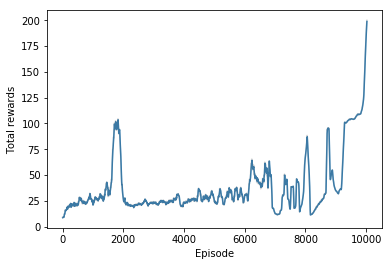

In [105]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

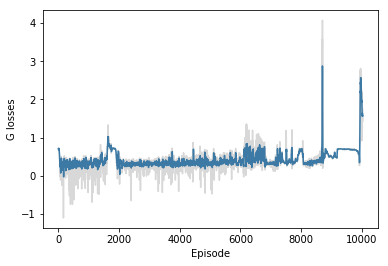

In [106]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

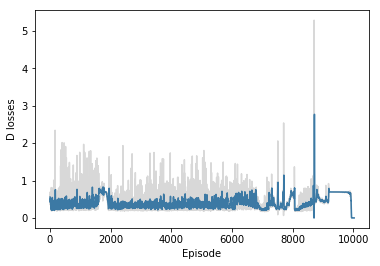

In [107]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [108]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.